# Data Import

MISSING SWAPTION IV DATA: 97 dates
2000-12-25 (Monday)
2001-12-25 (Tuesday)
2002-02-11 (Monday)
2002-03-29 (Friday)
2005-04-14 (Thursday)
2006-11-02 (Thursday)
2006-11-13 (Monday)
2006-12-01 (Friday)
2006-12-12 (Tuesday)
2006-12-18 (Monday)
2006-12-19 (Tuesday)
2006-12-22 (Friday)
2007-01-08 (Monday)
2007-05-07 (Monday)
2007-08-27 (Monday)
2008-04-24 (Thursday)
2008-05-05 (Monday)
2008-05-26 (Monday)
2008-08-25 (Monday)
2008-09-17 (Wednesday)
2009-01-09 (Friday)
2009-05-19 (Tuesday)
2009-05-20 (Wednesday)
2009-05-25 (Monday)
2009-07-02 (Thursday)
2009-07-09 (Thursday)
2009-08-10 (Monday)
2009-08-21 (Friday)
2009-09-22 (Tuesday)
2009-09-29 (Tuesday)
2009-10-01 (Thursday)
2009-10-02 (Friday)
2009-12-28 (Monday)
2010-01-26 (Tuesday)
2010-02-17 (Wednesday)
2010-02-18 (Thursday)
2010-03-03 (Wednesday)
2010-05-21 (Friday)
2010-05-31 (Monday)
2010-06-22 (Tuesday)
2010-09-13 (Monday)
2010-09-16 (Thursday)
2010-09-17 (Friday)
2010-12-16 (Thursday)
2011-02-21 (Monday)
2011-04-29 (Friday)
2011-05

C:\Users\westenb\AppData\Local\Temp\ipykernel_38852\3125458810.py:172: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


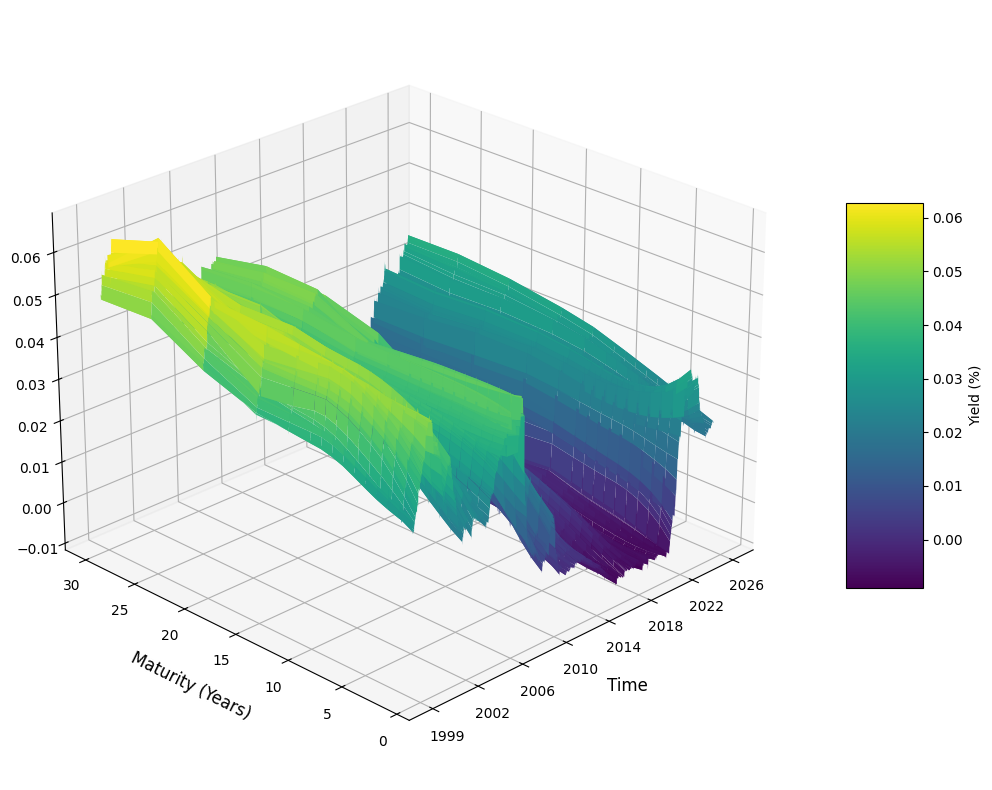


✓ 3D yield curve plot displayed for Germany (DE)


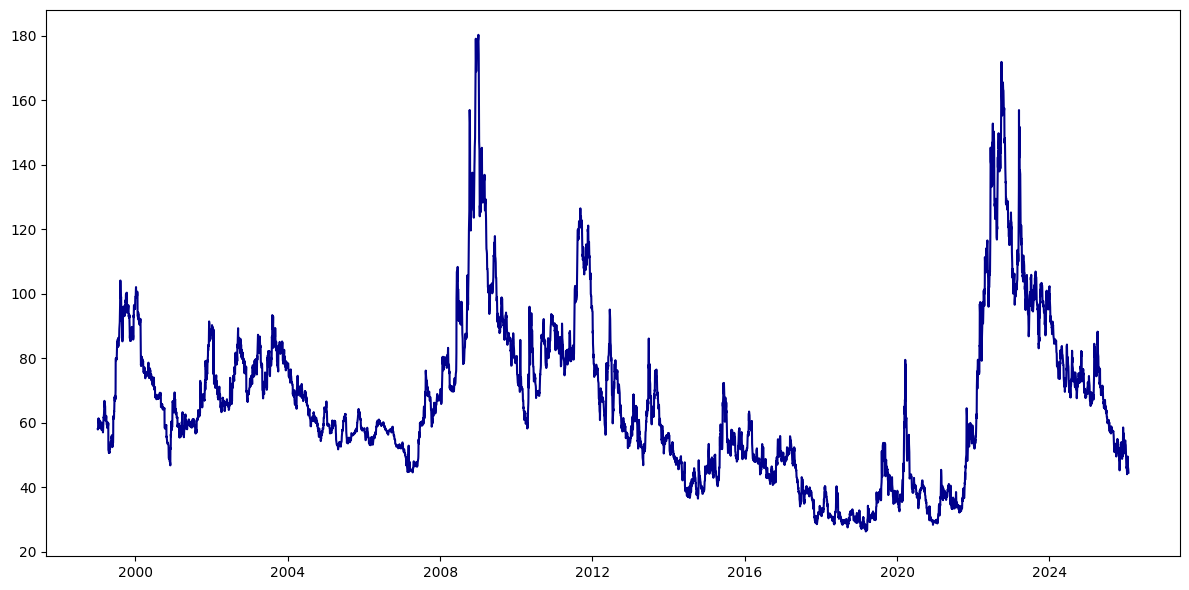


✓ Implied volatility plot displayed


In [10]:
# ============================================
# IMPORT YIELD CURVE DATA AND ANALYSIS
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os

# Define zero yield columns
zero_columns = ['ZERO_1Y', 'ZERO_2Y', 'ZERO_3Y', 'ZERO_4Y', 'ZERO_5Y', 
                'ZERO_6Y', 'ZERO_7Y', 'ZERO_8Y', 'ZERO_9Y', 'ZERO_10Y',
                'ZERO_12Y', 'ZERO_15Y', 'ZERO_20Y', 'ZERO_25Y', 'ZERO_30Y']

# ============================================
# 1. IMPORT DATA
# ============================================

# Define filepath as variable
filepath = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data"
filename = "DE_YieldCurve.csv"
full_path = os.path.join(filepath, filename)

# Import CSV
df = pd.read_csv(full_path)
df['REFERENCE_DATE'] = pd.to_datetime(df['REFERENCE_DATE'], format='ISO8601')

# Drop weekends (Saturday=5, Sunday=6)
df = df[df['REFERENCE_DATE'].dt.dayofweek < 5].reset_index(drop=True)

# Import Swaption IV data
iv_filename = "Swaption_3M_IV.csv"
iv_full_path = os.path.join(filepath, iv_filename)
df_iv = pd.read_csv(iv_full_path)
df_iv['Date'] = pd.to_datetime(df_iv['Date'], format='%d/%m/%Y')

# Merge IV data onto yield curve data (left join to keep all yield curve dates)
df = df.merge(df_iv, left_on='REFERENCE_DATE', right_on='Date', how='left')
df = df.drop(columns=['Date'])  # Remove duplicate date column

# Print missing IV dates
missing_iv = df[df['IV'].isna()]['REFERENCE_DATE']
if len(missing_iv) > 0:
    print("="*80)
    print(f"MISSING SWAPTION IV DATA: {len(missing_iv)} dates")
    print("="*80)
    for date in missing_iv:
        print(date.strftime('%Y-%m-%d (%A)'))
    print()

# Interpolate missing IV values linearly
df['IV'] = df['IV'].interpolate(method='linear', limit_direction='both')

# Check and interpolate any missing values in yield columns  
missing_yields = df[zero_columns].isnull().sum()
if missing_yields.any():
    print("="*80)
    print("MISSING YIELD DATA DETECTED - APPLYING LINEAR INTERPOLATION")
    print("="*80)
    print(missing_yields[missing_yields > 0])
    print()
    df[zero_columns] = df[zero_columns].interpolate(method='linear', limit_direction='both')



print("="*80)
print("YIELD CURVE DATA IMPORTED: GERMANY (DE)")
print("="*80)
print(f"File: {filename}")
print(f"Rows: {len(df)} (weekends excluded)")
print(f"Date range: {df['REFERENCE_DATE'].min().date()} to {df['REFERENCE_DATE'].max().date()}")
print(f"IV observations: {df['IV'].notna().sum()} ({df['IV'].notna().sum()/len(df)*100:.1f}%)")
print()



# ============================================
# 2. SUMMARY STATISTICS (ACADEMIC FORMAT)
# ============================================



# Add IV to statistics
stats_columns = zero_columns + ['IV']

# Calculate statistics
stats_df = pd.DataFrame({
    'Mean': df[stats_columns].mean(),
    'Std': df[stats_columns].std(),
    'Min': df[stats_columns].min(),
    'Q25': df[stats_columns].quantile(0.25),
    'Median': df[stats_columns].median(),
    'Q75': df[stats_columns].quantile(0.75),
    'Max': df[stats_columns].max(),
    'N': df[stats_columns].count()
})

print("="*80)
print("TABLE: SUMMARY STATISTICS OF ZERO-COUPON YIELD CURVES AND IMPLIED VOLATILITY")
print("="*80)
print("Market: Germany (DE)")
print(f"Sample period: {df['REFERENCE_DATE'].min().date()} to {df['REFERENCE_DATE'].max().date()}")
print(f"Observations: {len(df)}")
print()
print("All values in percentage points (%)")
print("-"*80)
print(stats_df.round(3).to_string())
print("="*80)
print()

# Additional statistics
print("ADDITIONAL STATISTICS")
print("-"*80)
print(f"Time series length: {len(df)} observations")
print(f"Total observation period: {(df['REFERENCE_DATE'].max() - df['REFERENCE_DATE'].min()).days} days")
print(f"Average observation frequency: {(df['REFERENCE_DATE'].max() - df['REFERENCE_DATE'].min()).days / len(df):.2f} days")
print()

# ============================================
# 3. 3D YIELD CURVE PLOT
# ============================================

# Create plotting copy with complete date range for smooth visualization
df_plot = df.copy()
date_range_plot = pd.bdate_range(start=df_plot['REFERENCE_DATE'].min(), 
                                  end=df_plot['REFERENCE_DATE'].max())
df_plot = df_plot.set_index('REFERENCE_DATE').reindex(date_range_plot)
df_plot[zero_columns] = df_plot[zero_columns].interpolate(method='cubic')  # Cubic for smoother
df_plot = df_plot.reset_index().rename(columns={'index': 'REFERENCE_DATE'})

# Prepare data for 3D plot
dates = df_plot['REFERENCE_DATE'].values
maturities = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]

# Create meshgrid
date_nums = np.arange(len(dates))
X, Y = np.meshgrid(date_nums, maturities)

# Create Z matrix (yields)
Z = df_plot[zero_columns].T.values

# Create 3D plot
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Surface plot with enhanced smoothing
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, 
                       linewidth=0, antialiased=True, alpha=1,
                       rcount=500, ccount=500,  # Higher = smoother
                       shade=True, lightsource=None)

# Labels
ax.set_xlabel('Time', fontsize=12, labelpad=10)
ax.set_ylabel('Maturity (Years)', fontsize=12, labelpad=10)
ax.set_zlabel('Zero Yield (%)', fontsize=12, labelpad=10)

# Set x-axis ticks to show only years
num_ticks = 8
tick_positions = np.linspace(0, len(dates)-1, num_ticks, dtype=int)
ax.set_xticks(tick_positions)
ax.set_xticklabels([pd.Timestamp(dates[i]).year for i in tick_positions], 
                    rotation=0, ha='center', fontsize=10)

# Colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Yield (%)')

# Adjust viewing angle
ax.view_init(elev=25, azim=225)

plt.tight_layout()
plt.show()

print("\n✓ 3D yield curve plot displayed for Germany (DE)")

# ============================================
# 4. IMPLIED VOLATILITY PLOT
# ============================================

# Filter data with non-null IV values
df_iv_plot = df[df['IV'].notna()]

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_iv_plot['REFERENCE_DATE'], df_iv_plot['IV'], color='darkblue', linewidth=1.5)
ax.grid(False)
plt.tight_layout()
plt.show()

print("\n✓ Implied volatility plot displayed")

# Yield Curve fitting for training purpouses

## PCA levels

In [11]:
# ============================================
# CREATE PCA TRAINING MATRIX FOR ANN (LEVELS)
# Using fixed lookback with future forecasts
# ============================================

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import os


print("="*80)
print("CREATING PCA TRAINING MATRIX ON LEVELS (df_pca)")
print("="*80)

# ============================================
# PARAMETERS
# ============================================

lookback = 756  # 3 years * 252 trading days
future = 21     # ~1 month in trading days
n_factors = 4   # Number of principal components

print(f"\nParameters:")
print(f"  Lookback window: {lookback} trading days ({lookback/252:.2f} years)")
print(f"  Forecast horizon: {future} trading days (~1 month)")
print(f"  Number of factors: {n_factors}")

# ============================================
# INITIALIZE STORAGE
# ============================================

# Define zero yield columns
zero_columns = ['ZERO_1Y', 'ZERO_2Y', 'ZERO_3Y', 'ZERO_4Y', 'ZERO_5Y', 
                'ZERO_6Y', 'ZERO_7Y', 'ZERO_8Y', 'ZERO_9Y', 'ZERO_10Y',
                'ZERO_12Y', 'ZERO_15Y', 'ZERO_20Y', 'ZERO_25Y', 'ZERO_30Y']

# Column names for loadings (15 maturities × n_factors PCs)
maturity_names = ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', 
                  '12Y', '15Y', '20Y', '25Y', '30Y']
loading_columns = []
for mat in maturity_names:
    for pc in range(1, n_factors + 1):
        loading_columns.append(f'L_{mat}_PC{pc}')

# Factor column names
current_factor_cols = [f'CURRENT_PC{i}' for i in range(1, n_factors + 1)]
future_factor_cols = [f'FUTURE_PC{i}' for i in range(1, n_factors + 1)]

# Eigenvalue column names
eigenval_cols = [f'EIGENVAL_{i}' for i in range(1, n_factors + 1)]

# All column names
columns = (
    ['CURRENT_DATE', 'FORECASTED_DATE'] +
    eigenval_cols +
    loading_columns +
    current_factor_cols + ['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT'] +
    future_factor_cols + ['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE']
)

# Initialize list to store rows
data_rows = []

print(f"\nTotal columns in df_pca: {len(columns)}")
print(f"  - 2 date columns")
print(f"  - {n_factors} eigenvalue columns")
print(f"  - {len(loading_columns)} loading columns (15 maturities × {n_factors} PCs)")
print(f"  - {n_factors + 3} current state columns ({n_factors} factors + RMSE + MAE + TAE)")
print(f"  - {n_factors + 3} future state columns ({n_factors} factors + RMSE + MAE + TAE)")

# ============================================
# GENERATE TRAINING MATRIX
# ============================================

print(f"\n{'='*80}")
print("GENERATING OBSERVATIONS...")
print("="*80)

# Starting index: need lookback history
start_idx = lookback

# Ending index: need future data available
end_idx = len(df) - future

n_observations = end_idx - start_idx

print(f"\nProcessing {n_observations} observations...")
print(f"  Start index: {start_idx} (date: {df.iloc[start_idx]['REFERENCE_DATE'].date()})")
print(f"  End index: {end_idx} (date: {df.iloc[end_idx]['REFERENCE_DATE'].date()})")
print(f"  Last forecast date: {df.iloc[end_idx + future - 1]['REFERENCE_DATE'].date()}")

# Progress tracking
progress_interval = max(1, n_observations // 10)

for i in range(start_idx, end_idx):
    # Progress indicator
    if (i - start_idx) % progress_interval == 0:
        progress = ((i - start_idx) / n_observations) * 100
        print(f"  Progress: {progress:.0f}% (observation {i-start_idx+1}/{n_observations})")
    
    # ============================================
    # 1. DEFINE DATES
    # ============================================
    
    current_idx = i
    future_idx = i + future
    
    current_date = df.iloc[current_idx]['REFERENCE_DATE']
    forecasted_date = df.iloc[future_idx]['REFERENCE_DATE']
    
    # ============================================
    # 2. ESTIMATE PCA ON LOOKBACK WINDOW
    # ============================================
    
    # Window: [current_idx - lookback : current_idx]
    window_start = current_idx - lookback
    window_end = current_idx
    
    Y_window = df.iloc[window_start:window_end][zero_columns].values
    
    # Fit PCA
    pca = PCA(n_components=n_factors)
    pca.fit(Y_window)
    
    # Get eigenvalues
    eigenvalues = pca.explained_variance_
    
    # Get loadings (15 × n_factors matrix)
    loadings = pca.components_.T  # Transpose to get (15 × n_factors)
    
    # Flatten loadings for storage (row-major order)
    loadings_flat = loadings.flatten()  # 15 * n_factors values
    
    # ============================================
    # 3. CURRENT STATE (using current loadings)
    # ============================================
    
    # Get current yield curve
    y_current = df.iloc[current_idx][zero_columns].values.reshape(1, -1)  # (1 × 15)
    
    # Calculate current factors: f = y @ L
    factors_current = y_current @ loadings  # (1 × n_factors)
    factors_current = factors_current.flatten()
    
    # Reconstruct current yield curve
    y_current_reconstructed = factors_current @ loadings.T  # (1 × 15)
    
    # Calculate errors
    errors_current = y_current.flatten() - y_current_reconstructed
    rmse_current = np.sqrt(np.mean(errors_current**2))
    mae_current = np.mean(np.abs(errors_current))
    tae_current = np.sum(np.abs(errors_current))
    
    # ============================================
    # 4. FUTURE STATE (using SAME loadings)
    # ============================================
    
    # Get future yield curve
    y_future = df.iloc[future_idx][zero_columns].values.reshape(1, -1)  # (1 × 15)
    
    # Calculate future factors using CURRENT loadings: f = y @ L_current
    factors_future = y_future @ loadings  # (1 × n_factors)
    factors_future = factors_future.flatten()
    
    # Reconstruct future yield curve using CURRENT loadings
    y_future_reconstructed = factors_future @ loadings.T  # (1 × 15)
    
    # Calculate errors
    errors_future = y_future.flatten() - y_future_reconstructed
    rmse_future = np.sqrt(np.mean(errors_future**2))
    mae_future = np.mean(np.abs(errors_future))
    tae_future = np.sum(np.abs(errors_future))
    
    # ============================================
    # 5. STORE ROW
    # ============================================
    
    row = [
        current_date,
        forecasted_date,
        *eigenvalues,  # 4 eigenvalue values
        *loadings_flat,  # 15 * n_factors loading values
        *factors_current,  # n_factors current factor values
        rmse_current, mae_current, tae_current,
        *factors_future,  # n_factors future factor values
        rmse_future, mae_future, tae_future
    ]
    
    data_rows.append(row)

# ============================================
# CREATE DATAFRAME
# ============================================

print(f"\n{'='*80}")
print("CREATING DATAFRAME...")
print("="*80)

df_pca = pd.DataFrame(data_rows, columns=columns)

print(f"\n✓ df_pca created successfully!")
print(f"  Shape: {df_pca.shape}")
print(f"  Columns: {len(df_pca.columns)}")
print(f"  Rows: {len(df_pca)}")

# ============================================
# CALCULATE PROPER RATIOS (FRESH vs STALE)
# ============================================

print(f"\n{'='*80}")
print("CALCULATING LOADING STABILITY RATIOS")
print("="*80)
print("\nComparing fresh loadings (L_t+h) vs stale loadings (L_t) for same yield curve at t+h")

# Initialize ratio columns with NaN
df_pca['RMSE_RATIO'] = np.nan
df_pca['MAE_RATIO'] = np.nan
df_pca['TAE_RATIO'] = np.nan

# For each row, find the corresponding "fresh" loadings row
ratio_count = 0
for idx in range(len(df_pca)):
    forecasted_date = df_pca.iloc[idx]['FORECASTED_DATE']
    
    # Find row where CURRENT_DATE equals this FORECASTED_DATE
    # This gives us the "fresh" loadings for that date
    fresh_row = df_pca[df_pca['CURRENT_DATE'] == forecasted_date]
    
    if len(fresh_row) > 0:
        fresh_row = fresh_row.iloc[0]
        
        # Calculate ratios: stale (FUTURE from current row) / fresh (CURRENT from matched row)
        rmse_ratio = df_pca.iloc[idx]['RMSE_FUTURE'] / fresh_row['RMSE_CURRENT']
        mae_ratio = df_pca.iloc[idx]['MAE_FUTURE'] / fresh_row['MAE_CURRENT']
        tae_ratio = df_pca.iloc[idx]['TAE_FUTURE'] / fresh_row['TAE_CURRENT']
        
        # Store ratios
        df_pca.at[idx, 'RMSE_RATIO'] = rmse_ratio
        df_pca.at[idx, 'MAE_RATIO'] = mae_ratio
        df_pca.at[idx, 'TAE_RATIO'] = tae_ratio
        
        ratio_count += 1

print(f"\n✓ Calculated ratios for {ratio_count} observations")
print(f"  Missing ratios (first {future} observations): {len(df_pca) - ratio_count}")

# ============================================
# SUMMARY STATISTICS
# ============================================

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nDate Range:")
print(f"  First current date: {df_pca['CURRENT_DATE'].min().date()}")
print(f"  Last current date: {df_pca['CURRENT_DATE'].max().date()}")
print(f"  First forecast date: {df_pca['FORECASTED_DATE'].min().date()}")
print(f"  Last forecast date: {df_pca['FORECASTED_DATE'].max().date()}")

print(f"\nEigenvalue Statistics:")
eigenval_stats = df_pca[eigenval_cols].describe()
print(eigenval_stats)

print(f"\nFactor Statistics (Current):")
factor_stats_current = df_pca[current_factor_cols].describe()
print(factor_stats_current.round(4))

print(f"\nFactor Statistics (Future):")
factor_stats_future = df_pca[future_factor_cols].describe()
print(factor_stats_future.round(4))

print(f"\nError Statistics (Current - Fresh Loadings):")
error_stats_current = df_pca[['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT']].describe()
print(error_stats_current)

print(f"\nError Statistics (Future - Stale Loadings):")
error_stats_future = df_pca[['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE']].describe()
print(error_stats_future)

print(f"\n{'='*80}")
print("TESTING L_t ≈ L_t+h ASSUMPTION (LEVELS)")
print("="*80)
print("\nComparing same yield curve reconstructed with fresh vs stale loadings")

# Summary statistics for ratios (excluding NaN)
ratio_stats = df_pca[['RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO']].describe()
print(f"\nRatio Statistics (Stale/Fresh):")
print(ratio_stats)

# Detailed interpretation for each metric
for metric in ['RMSE', 'MAE', 'TAE']:
    ratio_col = f'{metric}_RATIO'
    mean_ratio = df_pca[ratio_col].mean()
    median_ratio = df_pca[ratio_col].median()
    
    print(f"\n{metric} Ratio Analysis:")
    print(f"  Mean: {mean_ratio:.4f} (stale loadings increase {metric} by {(mean_ratio-1)*100:.1f}%)")
    print(f"  Median: {median_ratio:.4f} (stale loadings increase {metric} by {(median_ratio-1)*100:.1f}%)")
    
    if mean_ratio < 1.1:
        print(f"  ✓✓✓ EXCELLENT: Loading stability assumption is VALID")
    elif mean_ratio < 1.5:
        print(f"  ✓ ACCEPTABLE: Loading stability assumption is reasonable")
    else:
        print(f"  ✗ CONCERNING: Loading stability assumption may be questionable")

# ============================================
# SAVE TO CSV
# ============================================

print(f"\n{'='*80}")
print("SAVING df_pca TO CSV")
print("="*80)

save_path = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data"
filename = "PCA_fit.csv"
full_path = os.path.join(save_path, filename)

df_pca.to_csv(full_path, index=False)

print(f"\n✓ Saved: {filename}")
print(f"  Location: {save_path}")
print(f"  Rows: {len(df_pca)}")
print(f"  Columns: {len(df_pca.columns)}")

print(f"\n{'='*80}")
print("df_pca READY FOR ANN TRAINING")
print("="*80)

# Display first few rows
print(f"\nFirst 5 rows (selected columns):")
display_cols = (['CURRENT_DATE', 'FORECASTED_DATE'] + 
                eigenval_cols +
                current_factor_cols + ['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT'] +
                future_factor_cols + ['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE'] +
                ['RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO'])
print(df_pca[display_cols].head())

print(f"\n✓ Levels-based PCA matrix generation complete!")

CREATING PCA TRAINING MATRIX ON LEVELS (df_pca)

Parameters:
  Lookback window: 756 trading days (3.00 years)
  Forecast horizon: 21 trading days (~1 month)
  Number of factors: 4

Total columns in df_pca: 80
  - 2 date columns
  - 4 eigenvalue columns
  - 60 loading columns (15 maturities × 4 PCs)
  - 7 current state columns (4 factors + RMSE + MAE + TAE)
  - 7 future state columns (4 factors + RMSE + MAE + TAE)

GENERATING OBSERVATIONS...

Processing 6183 observations...
  Start index: 756 (date: 2001-11-27)
  End index: 6939 (date: 2025-12-31)
  Last forecast date: 2026-01-28
  Progress: 0% (observation 1/6183)
  Progress: 10% (observation 619/6183)
  Progress: 20% (observation 1237/6183)
  Progress: 30% (observation 1855/6183)
  Progress: 40% (observation 2473/6183)
  Progress: 50% (observation 3091/6183)
  Progress: 60% (observation 3709/6183)
  Progress: 70% (observation 4327/6183)
  Progress: 80% (observation 4945/6183)
  Progress: 90% (observation 5563/6183)
  Progress: 100% (o

## PCA changes

In [12]:
# ============================================
# COMPLETE YIELD CURVE CHANGES AND PCA ANALYSIS
# ============================================

import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA




# ============================================
# 2. CREATE YIELD CURVE CHANGES DATASET
# ============================================

print("\n" + "="*80)
print("CREATING YIELD CURVE CHANGES DATASET")
print("="*80)

# Define zero yield columns
zero_columns = ['ZERO_1Y', 'ZERO_2Y', 'ZERO_3Y', 'ZERO_4Y', 'ZERO_5Y', 
                'ZERO_6Y', 'ZERO_7Y', 'ZERO_8Y', 'ZERO_9Y', 'ZERO_10Y',
                'ZERO_12Y', 'ZERO_15Y', 'ZERO_20Y', 'ZERO_25Y', 'ZERO_30Y']

# CRITICAL: Start with a COPY of df to avoid any issues
df_changes = df.copy()

# Calculate changes IN PLACE on the copied dataframe
for col in zero_columns:
    df_changes[col] = df_changes[col].diff()

# Calculate change for IV
df_changes['IV'] = df_changes['IV'].diff()

# Check for any unexpected NaN values before dropping first row
print(f"\nBefore dropping first row:")
print(f"  Total rows: {len(df_changes)}")
print(f"  NaN count per column:")
for col in zero_columns + ['IV']:
    nan_count = df_changes[col].isna().sum()
    if nan_count > 1:  # Should only be 1 NaN (first row)
        print(f"    ⚠ WARNING: {col} has {nan_count} NaN values (expected 1)")

# Drop ONLY the first row (which has NaN from diff)
df_changes = df_changes.iloc[1:].reset_index(drop=True)

print(f"\n✓ Changes calculated successfully!")
print(f"  Original df rows: {len(df)}")
print(f"  df_changes rows: {len(df_changes)} (1 row dropped)")
print(f"  Expected: {len(df) - 1}")

# Verify no rows lost unexpectedly
if len(df_changes) != len(df) - 1:
    print(f"  ⚠ WARNING: Expected {len(df) - 1} rows but got {len(df_changes)}")
    print(f"  Missing {len(df) - 1 - len(df_changes)} rows!")
else:
    print(f"  ✓ Correct number of rows!")

print(f"  Date range: {df_changes['REFERENCE_DATE'].min().date()} to {df_changes['REFERENCE_DATE'].max().date()}")

# Check for any remaining NaN values
nan_check = df_changes[zero_columns + ['IV']].isna().sum()
if nan_check.sum() > 0:
    print(f"\n⚠ WARNING: NaN values found after dropping first row:")
    print(nan_check[nan_check > 0])

# ============================================
# 3. VERIFY DATES MATCH
# ============================================

print(f"\n{'='*80}")
print("DATE MATCHING VERIFICATION")
print("="*80)

# Get dates from original df (excluding first date)
df_dates_expected = set(df.iloc[1:]['REFERENCE_DATE'])

# Get dates from df_changes
df_changes_dates_actual = set(df_changes['REFERENCE_DATE'])

# Find missing dates
missing_dates = df_dates_expected - df_changes_dates_actual
extra_dates = df_changes_dates_actual - df_dates_expected

print(f"\nDate comparison:")
print(f"  Expected dates (df excluding first row): {len(df_dates_expected)}")
print(f"  Actual dates (df_changes): {len(df_changes_dates_actual)}")

if len(missing_dates) == 0 and len(extra_dates) == 0:
    print(f"  ✓✓✓ PERFECT: All dates match!")
else:
    if len(missing_dates) > 0:
        print(f"\n  ⚠ MISSING {len(missing_dates)} dates in df_changes:")
        for date in sorted(list(missing_dates))[:10]:  # Show first 10
            print(f"    {date.strftime('%Y-%m-%d (%A)')}")
    
    if len(extra_dates) > 0:
        print(f"\n  ⚠ EXTRA {len(extra_dates)} dates in df_changes (shouldn't happen):")
        for date in sorted(list(extra_dates))[:10]:  # Show first 10
            print(f"    {date.strftime('%Y-%m-%d (%A)')}")

# Verify first 10 dates match
print(f"\nFirst 10 dates comparison:")
print(f"  {'Original df':<20} {'df_changes':<20} {'Match'}")
print(f"  {'-'*20} {'-'*20} {'-'*5}")
for i in range(min(10, len(df_changes))):
    df_date = df.iloc[i+1]['REFERENCE_DATE'].strftime('%Y-%m-%d')  # +1 because first row dropped
    changes_date = df_changes.iloc[i]['REFERENCE_DATE'].strftime('%Y-%m-%d')
    match = "✓" if df_date == changes_date else "✗"
    print(f"  {df_date:<20} {changes_date:<20} {match}")

# Display summary statistics
print(f"\nChange Statistics (first 3 maturities):")
for col in zero_columns[:3]:
    print(f"  {col}: mean={df_changes[col].mean():.6f}, std={df_changes[col].std():.6f}")
print(f"  IV: mean={df_changes['IV'].mean():.6f}, std={df_changes['IV'].std():.6f}")

# Save to CSV
save_path = filepath
filename_changes = "DE_YieldCurve_Changes.csv"
full_path_changes = os.path.join(save_path, filename_changes)

df_changes.to_csv(full_path_changes, index=False)

print(f"\n✓ Saved: {filename_changes}")
print(f"  Location: {save_path}")
print(f"  Rows: {len(df_changes)}")
print(f"  Columns: {len(df_changes.columns)}")

# ============================================
# 4. CREATE PCA TRAINING MATRIX ON CHANGES
# ============================================

print("\n" + "="*80)
print("CREATING PCA TRAINING MATRIX ON CHANGES (df_pca_changes)")
print("="*80)

# ============================================
# PARAMETERS
# ============================================

lookback = 756  # 3 years * 252 trading days
future = 21     # ~1 month in trading days
n_factors = 4   # Number of principal components

print(f"\nParameters:")
print(f"  Lookback window: {lookback} trading days ({lookback/252:.2f} years)")
print(f"  Forecast horizon: {future} trading days (~1 month)")
print(f"  Number of factors: {n_factors}")

# ============================================
# INITIALIZE STORAGE
# ============================================

# Column names for loadings (15 maturities × n_factors PCs)
maturity_names = ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', 
                  '12Y', '15Y', '20Y', '25Y', '30Y']
loading_columns = []
for mat in maturity_names:
    for pc in range(1, n_factors + 1):
        loading_columns.append(f'L_{mat}_PC{pc}')

# Factor column names
current_factor_cols = [f'CURRENT_PC{i}' for i in range(1, n_factors + 1)]
future_factor_cols = [f'FUTURE_PC{i}' for i in range(1, n_factors + 1)]

# Eigenvalue column names
eigenval_cols = [f'EIGENVAL_{i}' for i in range(1, n_factors + 1)]

# All column names
columns = (
    ['CURRENT_DATE', 'FORECASTED_DATE'] +
    eigenval_cols +
    loading_columns +
    current_factor_cols + ['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT'] +
    future_factor_cols + ['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE']
)

# Initialize list to store rows
data_rows = []

print(f"\nTotal columns in df_pca_changes: {len(columns)}")
print(f"  - 2 date columns")
print(f"  - {n_factors} eigenvalue columns")
print(f"  - {len(loading_columns)} loading columns (15 maturities × {n_factors} PCs)")
print(f"  - {n_factors + 3} current state columns ({n_factors} factors + RMSE + MAE + TAE)")
print(f"  - {n_factors + 3} future state columns ({n_factors} factors + RMSE + MAE + TAE)")

# ============================================
# GENERATE TRAINING MATRIX
# ============================================

print(f"\n{'='*80}")
print("GENERATING OBSERVATIONS...")
print("="*80)

# Starting index: need lookback history
start_idx = lookback

# Ending index: need future data available
end_idx = len(df_changes) - future

n_observations = end_idx - start_idx

print(f"\nProcessing {n_observations} observations...")
print(f"  Start index: {start_idx} (date: {df_changes.iloc[start_idx]['REFERENCE_DATE'].date()})")
print(f"  End index: {end_idx} (date: {df_changes.iloc[end_idx]['REFERENCE_DATE'].date()})")
print(f"  Last forecast date: {df_changes.iloc[end_idx + future - 1]['REFERENCE_DATE'].date()}")

# Progress tracking
progress_interval = max(1, n_observations // 10)

for i in range(start_idx, end_idx):
    # Progress indicator
    if (i - start_idx) % progress_interval == 0:
        progress = ((i - start_idx) / n_observations) * 100
        print(f"  Progress: {progress:.0f}% (observation {i-start_idx+1}/{n_observations})")
    
    # ============================================
    # 1. DEFINE DATES
    # ============================================
    
    current_idx = i
    future_idx = i + future
    
    current_date = df_changes.iloc[current_idx]['REFERENCE_DATE']
    forecasted_date = df_changes.iloc[future_idx]['REFERENCE_DATE']
    
    # ============================================
    # 2. ESTIMATE PCA ON LOOKBACK WINDOW
    # ============================================
    
    # Window: [current_idx - lookback : current_idx]
    window_start = current_idx - lookback
    window_end = current_idx
    
    Y_window = df_changes.iloc[window_start:window_end][zero_columns].values
    
    # Fit PCA
    pca = PCA(n_components=n_factors)
    pca.fit(Y_window)
    
    # Get eigenvalues
    eigenvalues = pca.explained_variance_
    
    # Get loadings (15 × n_factors matrix)
    loadings = pca.components_.T  # Transpose to get (15 × n_factors)
    
    # Flatten loadings for storage (row-major order)
    loadings_flat = loadings.flatten()  # 15 * n_factors values
    
    # ============================================
    # 3. CURRENT STATE (using current loadings)
    # ============================================
    
    # Get current change
    y_current = df_changes.iloc[current_idx][zero_columns].values.reshape(1, -1)  # (1 × 15)
    
    # Calculate current factors: f = y @ L
    factors_current = y_current @ loadings  # (1 × n_factors)
    factors_current = factors_current.flatten()
    
    # Reconstruct current change
    y_current_reconstructed = factors_current @ loadings.T  # (1 × 15)
    
    # Calculate errors
    errors_current = y_current.flatten() - y_current_reconstructed
    rmse_current = np.sqrt(np.mean(errors_current**2))
    mae_current = np.mean(np.abs(errors_current))
    tae_current = np.sum(np.abs(errors_current))
    
    # ============================================
    # 4. FUTURE STATE (using SAME loadings)
    # ============================================
    
    # Get future change
    y_future = df_changes.iloc[future_idx][zero_columns].values.reshape(1, -1)  # (1 × 15)
    
    # Calculate future factors using CURRENT loadings: f = y @ L_current
    factors_future = y_future @ loadings  # (1 × n_factors)
    factors_future = factors_future.flatten()
    
    # Reconstruct future change using CURRENT loadings
    y_future_reconstructed = factors_future @ loadings.T  # (1 × 15)
    
    # Calculate errors
    errors_future = y_future.flatten() - y_future_reconstructed
    rmse_future = np.sqrt(np.mean(errors_future**2))
    mae_future = np.mean(np.abs(errors_future))
    tae_future = np.sum(np.abs(errors_future))
    
    # ============================================
    # 5. STORE ROW
    # ============================================
    
    row = [
        current_date,
        forecasted_date,
        *eigenvalues,  # 4 eigenvalue values
        *loadings_flat,  # 15 * n_factors loading values
        *factors_current,  # n_factors current factor values
        rmse_current, mae_current, tae_current,
        *factors_future,  # n_factors future factor values
        rmse_future, mae_future, tae_future
    ]
    
    data_rows.append(row)

# ============================================
# CREATE DATAFRAME
# ============================================

print(f"\n{'='*80}")
print("CREATING DATAFRAME...")
print("="*80)

df_pca_changes = pd.DataFrame(data_rows, columns=columns)

print(f"\n✓ df_pca_changes created successfully!")
print(f"  Shape: {df_pca_changes.shape}")
print(f"  Columns: {len(df_pca_changes.columns)}")
print(f"  Rows: {len(df_pca_changes)}")

# ============================================
# CALCULATE PROPER RATIOS (FRESH vs STALE)
# ============================================

print(f"\n{'='*80}")
print("CALCULATING LOADING STABILITY RATIOS")
print("="*80)
print("\nComparing fresh loadings (L_t+h) vs stale loadings (L_t) for same change at t+h")

# Initialize ratio columns with NaN
df_pca_changes['RMSE_RATIO'] = np.nan
df_pca_changes['MAE_RATIO'] = np.nan
df_pca_changes['TAE_RATIO'] = np.nan

# For each row, find the corresponding "fresh" loadings row
ratio_count = 0
for idx in range(len(df_pca_changes)):
    forecasted_date = df_pca_changes.iloc[idx]['FORECASTED_DATE']
    
    # Find row where CURRENT_DATE equals this FORECASTED_DATE
    fresh_row = df_pca_changes[df_pca_changes['CURRENT_DATE'] == forecasted_date]
    
    if len(fresh_row) > 0:
        fresh_row = fresh_row.iloc[0]
        
        # Calculate ratios: stale (FUTURE from current row) / fresh (CURRENT from matched row)
        rmse_ratio = df_pca_changes.iloc[idx]['RMSE_FUTURE'] / fresh_row['RMSE_CURRENT']
        mae_ratio = df_pca_changes.iloc[idx]['MAE_FUTURE'] / fresh_row['MAE_CURRENT']
        tae_ratio = df_pca_changes.iloc[idx]['TAE_FUTURE'] / fresh_row['TAE_CURRENT']
        
        # Store ratios
        df_pca_changes.at[idx, 'RMSE_RATIO'] = rmse_ratio
        df_pca_changes.at[idx, 'MAE_RATIO'] = mae_ratio
        df_pca_changes.at[idx, 'TAE_RATIO'] = tae_ratio
        
        ratio_count += 1

print(f"\n✓ Calculated ratios for {ratio_count} observations")
print(f"  Missing ratios (first {future} observations): {len(df_pca_changes) - ratio_count}")

# ============================================
# SUMMARY STATISTICS
# ============================================

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nDate Range:")
print(f"  First current date: {df_pca_changes['CURRENT_DATE'].min().date()}")
print(f"  Last current date: {df_pca_changes['CURRENT_DATE'].max().date()}")
print(f"  First forecast date: {df_pca_changes['FORECASTED_DATE'].min().date()}")
print(f"  Last forecast date: {df_pca_changes['FORECASTED_DATE'].max().date()}")

print(f"\nEigenvalue Statistics:")
eigenval_stats = df_pca_changes[eigenval_cols].describe()
print(eigenval_stats)

print(f"\nFactor Statistics (Current):")
factor_stats_current = df_pca_changes[current_factor_cols].describe()
print(factor_stats_current.round(6))

print(f"\nFactor Statistics (Future):")
factor_stats_future = df_pca_changes[future_factor_cols].describe()
print(factor_stats_future.round(6))

print(f"\nError Statistics (Current - Fresh Loadings):")
error_stats_current = df_pca_changes[['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT']].describe()
print(error_stats_current)

print(f"\nError Statistics (Future - Stale Loadings):")
error_stats_future = df_pca_changes[['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE']].describe()
print(error_stats_future)

print(f"\n{'='*80}")
print("TESTING L_t ≈ L_t+h ASSUMPTION (CHANGES)")
print("="*80)
print("\nComparing same yield change reconstructed with fresh vs stale loadings")

# Summary statistics for ratios (excluding NaN)
ratio_stats = df_pca_changes[['RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO']].describe()
print(f"\nRatio Statistics (Stale/Fresh):")
print(ratio_stats)

# Detailed interpretation for each metric
for metric in ['RMSE', 'MAE', 'TAE']:
    ratio_col = f'{metric}_RATIO'
    mean_ratio = df_pca_changes[ratio_col].mean()
    median_ratio = df_pca_changes[ratio_col].median()
    
    print(f"\n{metric} Ratio Analysis:")
    print(f"  Mean: {mean_ratio:.4f} (stale loadings increase {metric} by {(mean_ratio-1)*100:.1f}%)")
    print(f"  Median: {median_ratio:.4f} (stale loadings increase {metric} by {(median_ratio-1)*100:.1f}%)")
    
    if mean_ratio < 1.1:
        print(f"  ✓✓✓ EXCELLENT: Loading stability assumption is VALID")
    elif mean_ratio < 1.5:
        print(f"  ✓ ACCEPTABLE: Loading stability assumption is reasonable")
    else:
        print(f"  ✗ CONCERNING: Loading stability assumption may be questionable")

# ============================================
# SAVE TO CSV
# ============================================

print(f"\n{'='*80}")
print("SAVING df_pca_changes TO CSV")
print("="*80)

filename_pca = "PCA_fit_changes.csv"
full_path_pca = os.path.join(save_path, filename_pca)

df_pca_changes.to_csv(full_path_pca, index=False)

print(f"\n✓ Saved: {filename_pca}")
print(f"  Location: {save_path}")
print(f"  Rows: {len(df_pca_changes)}")
print(f"  Columns: {len(df_pca_changes.columns)}")

print(f"\n{'='*80}")
print("df_pca_changes READY FOR ANN TRAINING")
print("="*80)

# Display first few rows
print(f"\nFirst 5 rows (selected columns):")
display_cols = (['CURRENT_DATE', 'FORECASTED_DATE'] + 
                eigenval_cols +
                current_factor_cols + ['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT'] +
                future_factor_cols + ['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE'] +
                ['RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO'])
print(df_pca_changes[display_cols].head())

print(f"\n{'='*80}")
print("✓ COMPLETE - Changes-based PCA matrix generation complete!")
print("="*80)


CREATING YIELD CURVE CHANGES DATASET

Before dropping first row:
  Total rows: 6960
  NaN count per column:

✓ Changes calculated successfully!
  Original df rows: 6960
  df_changes rows: 6959 (1 row dropped)
  Expected: 6959
  ✓ Correct number of rows!
  Date range: 1999-01-05 to 2026-01-28

DATE MATCHING VERIFICATION

Date comparison:
  Expected dates (df excluding first row): 6959
  Actual dates (df_changes): 6959
  ✓✓✓ PERFECT: All dates match!

First 10 dates comparison:
  Original df          df_changes           Match
  -------------------- -------------------- -----
  1999-01-05           1999-01-05           ✓
  1999-01-06           1999-01-06           ✓
  1999-01-07           1999-01-07           ✓
  1999-01-08           1999-01-08           ✓
  1999-01-11           1999-01-11           ✓
  1999-01-12           1999-01-12           ✓
  1999-01-13           1999-01-13           ✓
  1999-01-14           1999-01-14           ✓
  1999-01-15           1999-01-15           ✓
  19

C:\Users\westenb\AppData\Local\Temp\ipykernel_38852\3925068457.py:351: RuntimeWarning: invalid value encountered in scalar divide
  rmse_ratio = df_pca_changes.iloc[idx]['RMSE_FUTURE'] / fresh_row['RMSE_CURRENT']
C:\Users\westenb\AppData\Local\Temp\ipykernel_38852\3925068457.py:352: RuntimeWarning: invalid value encountered in scalar divide
  mae_ratio = df_pca_changes.iloc[idx]['MAE_FUTURE'] / fresh_row['MAE_CURRENT']
C:\Users\westenb\AppData\Local\Temp\ipykernel_38852\3925068457.py:353: RuntimeWarning: invalid value encountered in scalar divide
  tae_ratio = df_pca_changes.iloc[idx]['TAE_FUTURE'] / fresh_row['TAE_CURRENT']



✓ Calculated ratios for 6161 observations
  Missing ratios (first 21 observations): 21

SUMMARY STATISTICS

Date Range:
  First current date: 2001-11-28
  Last current date: 2025-12-30
  First forecast date: 2001-12-27
  Last forecast date: 2026-01-28

Eigenvalue Statistics:
         EIGENVAL_1    EIGENVAL_2    EIGENVAL_3    EIGENVAL_4
count  6.182000e+03  6.182000e+03  6.182000e+03  6.182000e+03
mean   2.614309e-06  2.325619e-07  6.371166e-08  2.542796e-08
std    1.132772e-06  1.328246e-07  4.682489e-08  2.719603e-08
min    9.561319e-07  5.113021e-08  1.224962e-08  3.827908e-09
25%    1.730812e-06  1.346870e-07  2.838965e-08  8.064155e-09
50%    2.376777e-06  1.866091e-07  5.479025e-08  1.178770e-08
75%    3.475435e-06  3.187967e-07  8.110750e-08  2.813386e-08
max    5.538848e-06  5.704980e-07  2.040402e-07  1.292410e-07

Factor Statistics (Current):
       CURRENT_PC1  CURRENT_PC2  CURRENT_PC3  CURRENT_PC4
count  6182.000000  6182.000000  6182.000000  6182.000000
mean     -0.000012 

## Nelson-Siegel

In [13]:
# ============================================
# CREATE NELSON-SIEGEL TRAINING MATRIX
# Using fixed lookback with future forecasts
# Assumption: Lambda is locally stable
# ============================================

from scipy.optimize import minimize
import os

print("="*80)
print("CREATING NELSON-SIEGEL TRAINING MATRIX (df_ns)")
print("="*80)

# ============================================
# PARAMETERS
# ============================================

lookback = 756  # 3 years * 252 trading days
future = 21     # ~1 month in trading days

print(f"\nParameters:")
print(f"  Lookback window: {lookback} trading days ({lookback/252:.2f} years)")
print(f"  Forecast horizon: {future} trading days (~1 month)")
print(f"  Nelson-Siegel factors: 3 (Level, Slope, Curvature)")

# ============================================
# NELSON-SIEGEL FUNCTIONS
# ============================================

def nelson_siegel_loadings(tau, lambda_param):
    """Calculate Nelson-Siegel loadings for given maturities"""
    tau = np.array(tau, dtype=float)
    L1 = np.ones_like(tau)  # Level
    L2 = (1 - np.exp(-lambda_param * tau)) / (lambda_param * tau)  # Slope
    L3 = ((1 - np.exp(-lambda_param * tau)) / (lambda_param * tau)) - np.exp(-lambda_param * tau)  # Curvature
    return np.column_stack([L1, L2, L3])

def fit_nelson_siegel_lambda(Y_window, maturities):
    """Optimize lambda on rolling window"""
    def objective(lambda_param):
        if lambda_param <= 0:
            return 1e10
        try:
            total_error = 0
            loadings = nelson_siegel_loadings(maturities, lambda_param)
            for yields in Y_window:
                betas = np.linalg.lstsq(loadings, yields.astype(float), rcond=None)[0]
                fitted = loadings @ betas
                total_error += np.sum((yields - fitted)**2)
            return total_error
        except:
            return 1e10
    
    result = minimize(objective, x0=0.0609, bounds=[(0.001, 1.0)], method='L-BFGS-B')
    return result.x[0]

# ============================================
# INITIALIZE STORAGE
# ============================================

# Maturity setup
maturity_names = ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', 
                  '12Y', '15Y', '20Y', '25Y', '30Y']
maturities = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30], dtype=float)

# Column names
columns = (
    ['CURRENT_DATE', 'FORECASTED_DATE'] +
    ['LAMBDA'] +
    ['CURRENT_BETA0', 'CURRENT_BETA1', 'CURRENT_BETA2', 'RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT'] +
    ['FUTURE_BETA0', 'FUTURE_BETA1', 'FUTURE_BETA2', 'RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE']
)

# Initialize list to store rows
data_rows = []

print(f"\nTotal columns in df_ns: {len(columns)}")
print(f"  - 2 date columns")
print(f"  - 1 lambda parameter")
print(f"  - 6 current state columns (3 betas + RMSE + MAE + TAE)")
print(f"  - 6 future state columns (3 betas + RMSE + MAE + TAE)")

# ============================================
# GENERATE TRAINING MATRIX
# ============================================

print(f"\n{'='*80}")
print("GENERATING OBSERVATIONS...")
print("="*80)

# Starting index: need lookback history
start_idx = lookback

# Ending index: need future data available
end_idx = len(df) - future

n_observations = end_idx - start_idx

print(f"\nProcessing {n_observations} observations...")
print(f"  Start index: {start_idx} (date: {df.iloc[start_idx]['REFERENCE_DATE'].date()})")
print(f"  End index: {end_idx} (date: {df.iloc[end_idx]['REFERENCE_DATE'].date()})")
print(f"  Last forecast date: {df.iloc[end_idx + future - 1]['REFERENCE_DATE'].date()}")

# Progress tracking
progress_interval = max(1, n_observations // 10)

for i in range(start_idx, end_idx):
    # Progress indicator
    if (i - start_idx) % progress_interval == 0:
        progress = ((i - start_idx) / n_observations) * 100
        print(f"  Progress: {progress:.0f}% (observation {i-start_idx+1}/{n_observations})")
    
    # ============================================
    # 1. DEFINE DATES
    # ============================================
    
    current_idx = i
    future_idx = i + future
    
    current_date = df.iloc[current_idx]['REFERENCE_DATE']
    forecasted_date = df.iloc[future_idx]['REFERENCE_DATE']
    
    # ============================================
    # 2. ESTIMATE LAMBDA ON LOOKBACK WINDOW
    # ============================================
    
    # Window: [current_idx - lookback : current_idx]
    window_start = current_idx - lookback
    window_end = current_idx
    
    Y_window = df.iloc[window_start:window_end][zero_columns].values.astype(float)
    
    # Optimize lambda
    optimal_lambda = fit_nelson_siegel_lambda(Y_window, maturities)
    
    # Calculate loadings using optimal lambda
    ns_loadings = nelson_siegel_loadings(maturities, optimal_lambda)
    
    # ============================================
    # 3. CURRENT STATE (using current lambda)
    # ============================================
    
    # Get current yield curve
    y_current = df.iloc[current_idx][zero_columns].values.astype(float)
    
    # Fit betas for current curve
    betas_current = np.linalg.lstsq(ns_loadings, y_current, rcond=None)[0]
    
    # Reconstruct current yield curve
    y_current_reconstructed = ns_loadings @ betas_current
    
    # Calculate errors
    errors_current = y_current - y_current_reconstructed
    rmse_current = np.sqrt(np.mean(errors_current**2))
    mae_current = np.mean(np.abs(errors_current))
    tae_current = np.sum(np.abs(errors_current))
    
    # ============================================
    # 4. FUTURE STATE (using SAME lambda)
    # ============================================
    
    # Get future yield curve
    y_future = df.iloc[future_idx][zero_columns].values.astype(float)
    
    # Fit betas for future curve using CURRENT lambda
    betas_future = np.linalg.lstsq(ns_loadings, y_future, rcond=None)[0]
    
    # Reconstruct future yield curve using CURRENT lambda
    y_future_reconstructed = ns_loadings @ betas_future
    
    # Calculate errors
    errors_future = y_future - y_future_reconstructed
    rmse_future = np.sqrt(np.mean(errors_future**2))
    mae_future = np.mean(np.abs(errors_future))
    tae_future = np.sum(np.abs(errors_future))
    
    # ============================================
    # 5. STORE ROW
    # ============================================
    
    row = [
        current_date,
        forecasted_date,
        optimal_lambda,
        betas_current[0], betas_current[1], betas_current[2],  # Level, Slope, Curvature
        rmse_current, mae_current, tae_current,
        betas_future[0], betas_future[1], betas_future[2],
        rmse_future, mae_future, tae_future
    ]
    
    data_rows.append(row)

# ============================================
# CREATE DATAFRAME
# ============================================

print(f"\n{'='*80}")
print("CREATING DATAFRAME...")
print("="*80)

df_ns = pd.DataFrame(data_rows, columns=columns)

print(f"\n✓ df_ns created successfully!")
print(f"  Shape: {df_ns.shape}")
print(f"  Columns: {len(df_ns.columns)}")
print(f"  Rows: {len(df_ns)}")

# ============================================
# CALCULATE PROPER RATIOS (FRESH vs STALE)
# ============================================

print(f"\n{'='*80}")
print("CALCULATING LAMBDA STABILITY RATIOS")
print("="*80)
print("\nComparing fresh lambda (λ_t+h) vs stale lambda (λ_t) for same yield curve at t+h")

# Initialize ratio columns with NaN
df_ns['RMSE_RATIO'] = np.nan
df_ns['MAE_RATIO'] = np.nan
df_ns['TAE_RATIO'] = np.nan

# For each row, find the corresponding "fresh" lambda row
ratio_count = 0
for idx in range(len(df_ns)):
    forecasted_date = df_ns.iloc[idx]['FORECASTED_DATE']
    
    # Find row where CURRENT_DATE equals this FORECASTED_DATE
    # This gives us the "fresh" lambda for that date
    fresh_row = df_ns[df_ns['CURRENT_DATE'] == forecasted_date]
    
    if len(fresh_row) > 0:
        fresh_row = fresh_row.iloc[0]
        
        # Calculate ratios: stale (FUTURE from current row) / fresh (CURRENT from matched row)
        rmse_ratio = df_ns.iloc[idx]['RMSE_FUTURE'] / fresh_row['RMSE_CURRENT']
        mae_ratio = df_ns.iloc[idx]['MAE_FUTURE'] / fresh_row['MAE_CURRENT']
        tae_ratio = df_ns.iloc[idx]['TAE_FUTURE'] / fresh_row['TAE_CURRENT']
        
        # Store ratios
        df_ns.at[idx, 'RMSE_RATIO'] = rmse_ratio
        df_ns.at[idx, 'MAE_RATIO'] = mae_ratio
        df_ns.at[idx, 'TAE_RATIO'] = tae_ratio
        
        ratio_count += 1

print(f"\n✓ Calculated ratios for {ratio_count} observations")
print(f"  Missing ratios (first {future} observations): {len(df_ns) - ratio_count}")

# ============================================
# SUMMARY STATISTICS
# ============================================

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nDate Range:")
print(f"  First current date: {df_ns['CURRENT_DATE'].min().date()}")
print(f"  Last current date: {df_ns['CURRENT_DATE'].max().date()}")
print(f"  First forecast date: {df_ns['FORECASTED_DATE'].min().date()}")
print(f"  Last forecast date: {df_ns['FORECASTED_DATE'].max().date()}")

print(f"\nLambda Statistics:")
lambda_stats = df_ns[['LAMBDA']].describe()
print(lambda_stats.round(4))

print(f"\nBeta Statistics (Current):")
beta_stats_current = df_ns[['CURRENT_BETA0', 'CURRENT_BETA1', 'CURRENT_BETA2']].describe()
print(beta_stats_current.round(4))

print(f"\nBeta Statistics (Future):")
beta_stats_future = df_ns[['FUTURE_BETA0', 'FUTURE_BETA1', 'FUTURE_BETA2']].describe()
print(beta_stats_future.round(4))

print(f"\nError Statistics (Current - Fresh Lambda):")
error_stats_current = df_ns[['RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT']].describe()
print(error_stats_current)

print(f"\nError Statistics (Future - Stale Lambda):")
error_stats_future = df_ns[['RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE']].describe()
print(error_stats_future)

print(f"\n{'='*80}")
print("TESTING λ_t ≈ λ_t+h ASSUMPTION (CORRECTED METHOD)")
print("="*80)
print("\nComparing same yield curve reconstructed with fresh vs stale lambda")

# Summary statistics for ratios (excluding NaN)
ratio_stats = df_ns[['RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO']].describe()
print(f"\nRatio Statistics (Stale/Fresh):")
print(ratio_stats)

# Detailed interpretation for each metric
for metric in ['RMSE', 'MAE', 'TAE']:
    ratio_col = f'{metric}_RATIO'
    mean_ratio = df_ns[ratio_col].mean()
    median_ratio = df_ns[ratio_col].median()
    
    print(f"\n{metric} Ratio Analysis:")
    print(f"  Mean: {mean_ratio:.4f} (stale lambda increases {metric} by {(mean_ratio-1)*100:.1f}%)")
    print(f"  Median: {median_ratio:.4f} (stale lambda increases {metric} by {(median_ratio-1)*100:.1f}%)")
    
    if mean_ratio < 1.1:
        print(f"  ✓✓✓ EXCELLENT: Lambda stability assumption is VALID")
    elif mean_ratio < 1.5:
        print(f"  ✓ ACCEPTABLE: Lambda stability assumption is reasonable")
    else:
        print(f"  ✗ CONCERNING: Lambda stability assumption may be questionable")

# ============================================
# SAVE TO CSV
# ============================================

print(f"\n{'='*80}")
print("SAVING df_ns TO CSV")
print("="*80)

save_path = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data"
filename = "NS_fit.csv"
full_path = os.path.join(save_path, filename)

df_ns.to_csv(full_path, index=False)

print(f"\n✓ Saved: {filename}")
print(f"  Location: {save_path}")
print(f"  Rows: {len(df_ns)}")
print(f"  Columns: {len(df_ns.columns)}")

print(f"\n{'='*80}")
print("df_ns READY FOR COMPARISON WITH df_pca")
print("="*80)

# Display first few rows
print(f"\nFirst 5 rows:")
display_cols = ['CURRENT_DATE', 'FORECASTED_DATE', 'LAMBDA',
                'CURRENT_BETA0', 'CURRENT_BETA1', 'CURRENT_BETA2',
                'RMSE_CURRENT', 'MAE_CURRENT', 'TAE_CURRENT',
                'FUTURE_BETA0', 'FUTURE_BETA1', 'FUTURE_BETA2',
                'RMSE_FUTURE', 'MAE_FUTURE', 'TAE_FUTURE',
                'RMSE_RATIO', 'MAE_RATIO', 'TAE_RATIO']
print(df_ns[display_cols].head())

print(f"\n✓ Matrix generation complete!")

CREATING NELSON-SIEGEL TRAINING MATRIX (df_ns)

Parameters:
  Lookback window: 756 trading days (3.00 years)
  Forecast horizon: 21 trading days (~1 month)
  Nelson-Siegel factors: 3 (Level, Slope, Curvature)

Total columns in df_ns: 15
  - 2 date columns
  - 1 lambda parameter
  - 6 current state columns (3 betas + RMSE + MAE + TAE)
  - 6 future state columns (3 betas + RMSE + MAE + TAE)

GENERATING OBSERVATIONS...

Processing 6183 observations...
  Start index: 756 (date: 2001-11-27)
  End index: 6939 (date: 2025-12-31)
  Last forecast date: 2026-01-28
  Progress: 0% (observation 1/6183)
  Progress: 10% (observation 619/6183)
  Progress: 20% (observation 1237/6183)
  Progress: 30% (observation 1855/6183)
  Progress: 40% (observation 2473/6183)
  Progress: 50% (observation 3091/6183)
  Progress: 60% (observation 3709/6183)
  Progress: 70% (observation 4327/6183)
  Progress: 80% (observation 4945/6183)
  Progress: 90% (observation 5563/6183)
  Progress: 100% (observation 6181/6183)

CR

## Showing future fits on the yield curve

In [16]:
# ============================================
# YIELD CURVE RECONSTRUCTION & VISUALIZATION
# Block 3: Create df_forecastyields using df_pca, df_pca_changes, and df_ns
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("LOADING PCA AND NS FITTING DATA")
print("="*80)

# ============================================
# LOAD DATA FROM CSV FILES
# ============================================

filepath = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data"

# Load dataframes
df_pca = pd.read_csv(filepath + r"\PCA_fit.csv")
df_pca_changes = pd.read_csv(filepath + r"\PCA_fit_changes.csv")
df_ns = pd.read_csv(filepath + r"\NS_fit.csv")

# Convert dates
df_pca['CURRENT_DATE'] = pd.to_datetime(df_pca['CURRENT_DATE'])
df_pca['FORECASTED_DATE'] = pd.to_datetime(df_pca['FORECASTED_DATE'])
df_pca_changes['CURRENT_DATE'] = pd.to_datetime(df_pca_changes['CURRENT_DATE'])
df_pca_changes['FORECASTED_DATE'] = pd.to_datetime(df_pca_changes['FORECASTED_DATE'])
df_ns['CURRENT_DATE'] = pd.to_datetime(df_ns['CURRENT_DATE'])
df_ns['FORECASTED_DATE'] = pd.to_datetime(df_ns['FORECASTED_DATE'])

print(f"\n✓ Data loaded successfully!")
print(f"  df_pca: {len(df_pca)} rows")
print(f"  df_pca_changes: {len(df_pca_changes)} rows")
print(f"  df_ns: {len(df_ns)} rows")

# ============================================
# ALIGN DATAFRAMES (DROP FIRST ROW FROM LEVEL & NS)
# ============================================

print("\n" + "="*80)
print("ALIGNING DATAFRAMES")
print("="*80)

# df_pca_changes has one less row because it's based on df_changes (first row dropped from diff)
# Drop first row from df_pca and df_ns to align
df_pca = df_pca.iloc[1:].reset_index(drop=True)
df_ns = df_ns.iloc[1:].reset_index(drop=True)

print(f"\n✓ Dropped first observation from df_pca and df_ns to align with df_pca_changes")
print(f"  df_pca: {len(df_pca)} rows")
print(f"  df_pca_changes: {len(df_pca_changes)} rows")
print(f"  df_ns: {len(df_ns)} rows")

# Verify all dataframes have same length
assert len(df_pca) == len(df_ns), "df_pca and df_ns must have same length!"
assert len(df_pca) == len(df_pca_changes), "df_pca and df_pca_changes must have same length!"

n_obs = len(df_pca)
print(f"\n✓ Verified: All dataframes have {n_obs} observations")

# ============================================
# CREATING FORECASTED YIELDS DATAFRAME
# ============================================

print("\n" + "="*80)
print("CREATING FORECASTED YIELDS DATAFRAME")
print("="*80)

# ============================================
# DETECT NUMBER OF FACTORS FROM df_pca
# ============================================

future_factor_cols = [col for col in df_pca.columns if col.startswith('FUTURE_PC')]
n_factors_detected = len(future_factor_cols)

print(f"\nDetected {n_factors_detected} factors from df_pca")

# ============================================
# NELSON-SIEGEL LOADINGS FUNCTION
# ============================================

def nelson_siegel_loadings(tau, lambda_param):
    """Calculate Nelson-Siegel loadings for given maturities"""
    tau = np.array(tau, dtype=float)
    L1 = np.ones_like(tau)
    L2 = (1 - np.exp(-lambda_param * tau)) / (lambda_param * tau)
    L3 = ((1 - np.exp(-lambda_param * tau)) / (lambda_param * tau)) - np.exp(-lambda_param * tau)
    return np.column_stack([L1, L2, L3])

# ============================================
# SETUP
# ============================================

maturity_names = ['1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', 
                  '12Y', '15Y', '20Y', '25Y', '30Y']
maturities = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30], dtype=float)
zero_columns = ['ZERO_1Y', 'ZERO_2Y', 'ZERO_3Y', 'ZERO_4Y', 'ZERO_5Y', 
                'ZERO_6Y', 'ZERO_7Y', 'ZERO_8Y', 'ZERO_9Y', 'ZERO_10Y',
                'ZERO_12Y', 'ZERO_15Y', 'ZERO_20Y', 'ZERO_25Y', 'ZERO_30Y']

# ============================================
# STEP 1: RECONSTRUCT YIELDS FROM df_pca, df_pca_changes, AND df_ns
# ============================================

print("\n" + "="*80)
print("STEP 1: RECONSTRUCTING YIELDS FROM STORED DATA")
print("="*80)

# Pre-allocate arrays
pca_level_yields_all = np.zeros((n_obs, 15))
pca_changes_yields_all = np.zeros((n_obs, 15))
ns_yields_all = np.zeros((n_obs, 15))

print("Processing PCA Level, PCA Changes, and NS reconstructions...")

progress_interval = max(1, n_obs // 10)

for idx in range(n_obs):
    if idx % progress_interval == 0:
        print(f"  Progress: {(idx / n_obs) * 100:.0f}% (observation {idx+1}/{n_obs})")
    
    # ============================================
    # PCA LEVEL RECONSTRUCTION (from df_pca)
    # ============================================
    
    # Get future factors
    future_factors_level = df_pca.iloc[idx][future_factor_cols].values
    
    # Extract loadings
    loading_columns = [col for col in df_pca.columns if col.startswith('L_')]
    loadings_flat_level = df_pca.iloc[idx][loading_columns].values
    loadings_level = loadings_flat_level.reshape(15, n_factors_detected)
    
    # Reconstruct yields: y = f @ L.T
    pca_level_yields_all[idx] = future_factors_level @ loadings_level.T
    
    # ============================================
    # PCA CHANGES RECONSTRUCTION (from df_pca_changes)
    # ============================================
    
    # Get future factors (these represent the change factors)
    future_factors_changes = df_pca_changes.iloc[idx][future_factor_cols].values
    
    # Extract loadings for changes
    loading_columns_changes = [col for col in df_pca_changes.columns if col.startswith('L_')]
    loadings_flat_changes = df_pca_changes.iloc[idx][loading_columns_changes].values
    loadings_changes = loadings_flat_changes.reshape(15, n_factors_detected)
    
    # Reconstruct CHANGE: Δy = f @ L.T
    delta_y_reconstructed = future_factors_changes @ loadings_changes.T
    
    # Get CURRENT yield level from df
    current_date = df_pca_changes.iloc[idx]['CURRENT_DATE']
    current_row = df[df['REFERENCE_DATE'] == current_date]
    y_current = current_row[zero_columns].values.flatten()
    
    # Forecast: y_{t+h} = y_t + Δy_{t+h}
    pca_changes_yields_all[idx] = y_current + delta_y_reconstructed
    
    # ============================================
    # NELSON-SIEGEL RECONSTRUCTION (from df_ns)
    # ============================================
    
    # Get lambda and future betas
    lambda_opt = df_ns.iloc[idx]['LAMBDA']
    future_betas = df_ns.iloc[idx][['FUTURE_BETA0', 'FUTURE_BETA1', 'FUTURE_BETA2']].values
    
    # Compute loadings
    ns_loadings = nelson_siegel_loadings(maturities, lambda_opt)
    
    # Reconstruct yields: y = L @ β
    ns_yields_all[idx] = ns_loadings @ future_betas

print(f"\n✓ Reconstructions complete!")

# ============================================
# STEP 2: GET ACTUAL YIELDS FOR VERIFICATION
# ============================================

print("\n" + "="*80)
print("STEP 2: EXTRACTING ACTUAL YIELDS")
print("="*80)

# Get future actual yields from df based on forecasted dates
y_future_actual_all = np.zeros((n_obs, 15))
for idx in range(n_obs):
    forecasted_date = df_pca.iloc[idx]['FORECASTED_DATE']
    actual_row = df[df['REFERENCE_DATE'] == forecasted_date]
    if len(actual_row) > 0:
        y_future_actual_all[idx] = actual_row[zero_columns].values.flatten()

# Verify PCA Level and NS errors match what's stored
print("\nVerifying error calculations...")

# PCA Level verification (should match df_pca['RMSE_FUTURE'])
pca_level_errors_verify = y_future_actual_all - pca_level_yields_all
rmse_pca_level_verify = np.sqrt(np.mean(pca_level_errors_verify**2, axis=1))
rmse_pca_level_stored = df_pca['RMSE_FUTURE'].values
pca_level_match = np.allclose(rmse_pca_level_verify, rmse_pca_level_stored, rtol=1e-5)
print(f"  PCA Level errors match stored values: {pca_level_match}")

# NS verification (should match df_ns['RMSE_FUTURE'])
ns_errors_verify = y_future_actual_all - ns_yields_all
rmse_ns_verify = np.sqrt(np.mean(ns_errors_verify**2, axis=1))
rmse_ns_stored = df_ns['RMSE_FUTURE'].values
ns_match = np.allclose(rmse_ns_verify, rmse_ns_stored, rtol=1e-5)
print(f"  NS errors match stored values: {ns_match}")

# Calculate PCA Changes errors (compute fresh, not stored)
pca_changes_errors = y_future_actual_all - pca_changes_yields_all
rmse_pca_changes = np.sqrt(np.mean(pca_changes_errors**2, axis=1))
mae_pca_changes = np.mean(np.abs(pca_changes_errors), axis=1)
tae_pca_changes = np.sum(np.abs(pca_changes_errors), axis=1)
print(f"  PCA Changes errors calculated from reconstructions")

# ============================================
# STEP 3: EXTRACT ERROR METRICS
# ============================================

print("\n" + "="*80)
print("STEP 3: EXTRACTING ERROR METRICS")
print("="*80)

# PCA Level errors (from df_pca)
rmse_pca_level = df_pca['RMSE_FUTURE'].values
mae_pca_level = df_pca['MAE_FUTURE'].values
tae_pca_level = df_pca['TAE_FUTURE'].values

# PCA Level stability ratios (from df_pca)
rmse_ratio_pca_level = df_pca['RMSE_RATIO'].values
mae_ratio_pca_level = df_pca['MAE_RATIO'].values
tae_ratio_pca_level = df_pca['TAE_RATIO'].values

# PCA Changes stability ratios (from df_pca_changes)
rmse_ratio_pca_changes = df_pca_changes['RMSE_RATIO'].values
mae_ratio_pca_changes = df_pca_changes['MAE_RATIO'].values
tae_ratio_pca_changes = df_pca_changes['TAE_RATIO'].values

# NS errors (from df_ns)
rmse_ns = df_ns['RMSE_FUTURE'].values
mae_ns = df_ns['MAE_FUTURE'].values
tae_ns = df_ns['TAE_FUTURE'].values

# NS stability ratios (from df_ns)
rmse_ratio_ns = df_ns['RMSE_RATIO'].values
mae_ratio_ns = df_ns['MAE_RATIO'].values
tae_ratio_ns = df_ns['TAE_RATIO'].values

# Comparison ratios
# PCA Level / NS
rmse_pca_level_ns_ratio = np.where(rmse_ns > 0, rmse_pca_level / rmse_ns, np.nan)
mae_pca_level_ns_ratio = np.where(mae_ns > 0, mae_pca_level / mae_ns, np.nan)
tae_pca_level_ns_ratio = np.where(tae_ns > 0, tae_pca_level / tae_ns, np.nan)

# PCA Level / PCA Changes
rmse_pca_level_changes_ratio = np.where(rmse_pca_changes > 0, rmse_pca_level / rmse_pca_changes, np.nan)
mae_pca_level_changes_ratio = np.where(mae_pca_changes > 0, mae_pca_level / mae_pca_changes, np.nan)
tae_pca_level_changes_ratio = np.where(tae_pca_changes > 0, tae_pca_level / tae_pca_changes, np.nan)

# PCA Changes / NS
rmse_pca_changes_ns_ratio = np.where(rmse_ns > 0, rmse_pca_changes / rmse_ns, np.nan)
mae_pca_changes_ns_ratio = np.where(mae_ns > 0, mae_pca_changes / mae_ns, np.nan)
tae_pca_changes_ns_ratio = np.where(tae_ns > 0, tae_pca_changes / tae_ns, np.nan)

print(f"✓ Error metrics extracted")

# ============================================
# STEP 4: CREATE df_forecastyields
# ============================================

print("\n" + "="*80)
print("STEP 4: CREATING df_forecastyields")
print("="*80)

forecast_columns = (['FORECASTED_DATE'] +
                   [f'PCA_LEVEL_{mat}' for mat in maturity_names] +
                   ['RMSE_PCA_LEVEL', 'MAE_PCA_LEVEL', 'TAE_PCA_LEVEL'] +
                   ['RMSE_RATIO_PCA_LEVEL', 'MAE_RATIO_PCA_LEVEL', 'TAE_RATIO_PCA_LEVEL'] +
                   [f'PCA_CHANGES_{mat}' for mat in maturity_names] +
                   ['RMSE_PCA_CHANGES', 'MAE_PCA_CHANGES', 'TAE_PCA_CHANGES'] +
                   ['RMSE_RATIO_PCA_CHANGES', 'MAE_RATIO_PCA_CHANGES', 'TAE_RATIO_PCA_CHANGES'] +
                   [f'NS_{mat}' for mat in maturity_names] +
                   ['RMSE_NS', 'MAE_NS', 'TAE_NS'] +
                   ['RMSE_RATIO_NS', 'MAE_RATIO_NS', 'TAE_RATIO_NS'] +
                   ['RMSE_PCA_LEVEL_NS_RATIO', 'MAE_PCA_LEVEL_NS_RATIO', 'TAE_PCA_LEVEL_NS_RATIO'] +
                   ['RMSE_PCA_LEVEL_CHANGES_RATIO', 'MAE_PCA_LEVEL_CHANGES_RATIO', 'TAE_PCA_LEVEL_CHANGES_RATIO'] +
                   ['RMSE_PCA_CHANGES_NS_RATIO', 'MAE_PCA_CHANGES_NS_RATIO', 'TAE_PCA_CHANGES_NS_RATIO'])

# Build data array
data = np.column_stack([
    pca_level_yields_all,
    rmse_pca_level.reshape(-1, 1), mae_pca_level.reshape(-1, 1), tae_pca_level.reshape(-1, 1),
    rmse_ratio_pca_level.reshape(-1, 1), mae_ratio_pca_level.reshape(-1, 1), tae_ratio_pca_level.reshape(-1, 1),
    pca_changes_yields_all,
    rmse_pca_changes.reshape(-1, 1), mae_pca_changes.reshape(-1, 1), tae_pca_changes.reshape(-1, 1),
    rmse_ratio_pca_changes.reshape(-1, 1), mae_ratio_pca_changes.reshape(-1, 1), tae_ratio_pca_changes.reshape(-1, 1),
    ns_yields_all,
    rmse_ns.reshape(-1, 1), mae_ns.reshape(-1, 1), tae_ns.reshape(-1, 1),
    rmse_ratio_ns.reshape(-1, 1), mae_ratio_ns.reshape(-1, 1), tae_ratio_ns.reshape(-1, 1),
    rmse_pca_level_ns_ratio.reshape(-1, 1), mae_pca_level_ns_ratio.reshape(-1, 1), tae_pca_level_ns_ratio.reshape(-1, 1),
    rmse_pca_level_changes_ratio.reshape(-1, 1), mae_pca_level_changes_ratio.reshape(-1, 1), tae_pca_level_changes_ratio.reshape(-1, 1),
    rmse_pca_changes_ns_ratio.reshape(-1, 1), mae_pca_changes_ns_ratio.reshape(-1, 1), tae_pca_changes_ns_ratio.reshape(-1, 1)
])

df_forecastyields = pd.DataFrame(data, columns=forecast_columns[1:])  # Exclude date column
df_forecastyields.insert(0, 'FORECASTED_DATE', df_pca['FORECASTED_DATE'].values)

print(f"\n✓ df_forecastyields created!")
print(f"  Shape: {df_forecastyields.shape}")
print(f"  Columns: {len(df_forecastyields.columns)}")

# ============================================
# SUMMARY STATISTICS
# ============================================

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print("\nPCA Level Error Statistics:")
print(df_forecastyields[['RMSE_PCA_LEVEL', 'MAE_PCA_LEVEL', 'TAE_PCA_LEVEL']].describe())

print("\nPCA Level Stability Ratios (Stale/Fresh Loadings):")
print(df_forecastyields[['RMSE_RATIO_PCA_LEVEL', 'MAE_RATIO_PCA_LEVEL', 'TAE_RATIO_PCA_LEVEL']].describe())

print("\nPCA Changes Error Statistics:")
print(df_forecastyields[['RMSE_PCA_CHANGES', 'MAE_PCA_CHANGES', 'TAE_PCA_CHANGES']].describe())

print("\nPCA Changes Stability Ratios (Stale/Fresh Loadings):")
print(df_forecastyields[['RMSE_RATIO_PCA_CHANGES', 'MAE_RATIO_PCA_CHANGES', 'TAE_RATIO_PCA_CHANGES']].describe())

print("\nNelson-Siegel Error Statistics:")
print(df_forecastyields[['RMSE_NS', 'MAE_NS', 'TAE_NS']].describe())

print("\nNS Stability Ratios (Stale/Fresh Lambda):")
print(df_forecastyields[['RMSE_RATIO_NS', 'MAE_RATIO_NS', 'TAE_RATIO_NS']].describe())

print("\nPCA Level / NS Comparison Ratios (< 1.0 means PCA Level better):")
print(df_forecastyields[['RMSE_PCA_LEVEL_NS_RATIO', 'MAE_PCA_LEVEL_NS_RATIO', 'TAE_PCA_LEVEL_NS_RATIO']].describe())

print("\nPCA Level / PCA Changes Comparison Ratios (< 1.0 means PCA Level better):")
print(df_forecastyields[['RMSE_PCA_LEVEL_CHANGES_RATIO', 'MAE_PCA_LEVEL_CHANGES_RATIO', 'TAE_PCA_LEVEL_CHANGES_RATIO']].describe())

print("\nPCA Changes / NS Comparison Ratios (< 1.0 means PCA Changes better):")
print(df_forecastyields[['RMSE_PCA_CHANGES_NS_RATIO', 'MAE_PCA_CHANGES_NS_RATIO', 'TAE_PCA_CHANGES_NS_RATIO']].describe())

# ============================================
# INTERESTING DATES ANALYSIS
# ============================================

print("\n" + "="*80)
print("INTERESTING DATES FOR ANALYSIS")
print("="*80)

print("\nTOP 5 WORST PCA LEVEL FITS (Highest RMSE):")
print("-"*80)
worst_pca_level_rmse = df_forecastyields.nlargest(5, 'RMSE_PCA_LEVEL')[['FORECASTED_DATE', 'RMSE_PCA_LEVEL', 'MAE_PCA_LEVEL', 'TAE_PCA_LEVEL']]
print(worst_pca_level_rmse.to_string(index=False))

print("\nTOP 5 WORST PCA CHANGES FITS (Highest RMSE):")
print("-"*80)
worst_pca_changes_rmse = df_forecastyields.nlargest(5, 'RMSE_PCA_CHANGES')[['FORECASTED_DATE', 'RMSE_PCA_CHANGES', 'MAE_PCA_CHANGES', 'TAE_PCA_CHANGES']]
print(worst_pca_changes_rmse.to_string(index=False))

print("\nTOP 5 WORST NS FITS (Highest RMSE):")
print("-"*80)
worst_ns_rmse = df_forecastyields.nlargest(5, 'RMSE_NS')[['FORECASTED_DATE', 'RMSE_NS', 'MAE_NS', 'TAE_NS']]
print(worst_ns_rmse.to_string(index=False))

# ============================================
# OVERALL COMPARISON
# ============================================

print("\n" + "="*80)
print("OVERALL METHOD COMPARISON")
print("="*80)

# PCA Level vs NS
mean_rmse_level_ns = df_forecastyields['RMSE_PCA_LEVEL_NS_RATIO'].mean()
median_rmse_level_ns = df_forecastyields['RMSE_PCA_LEVEL_NS_RATIO'].median()
pca_level_wins_ns = (df_forecastyields['RMSE_PCA_LEVEL_NS_RATIO'] < 1.0).sum()

print(f"\nPCA Level vs NS:")
print(f"  Mean ratio: {mean_rmse_level_ns:.4f} (PCA Level {abs((1-mean_rmse_level_ns)*100):.1f}% {'better' if mean_rmse_level_ns < 1 else 'worse'})")
print(f"  Median ratio: {median_rmse_level_ns:.4f} (PCA Level {abs((1-median_rmse_level_ns)*100):.1f}% {'better' if median_rmse_level_ns < 1 else 'worse'})")
print(f"  PCA Level wins: {pca_level_wins_ns}/{n_obs} ({pca_level_wins_ns/n_obs*100:.1f}%)")

# PCA Level vs PCA Changes
mean_rmse_level_changes = df_forecastyields['RMSE_PCA_LEVEL_CHANGES_RATIO'].mean()
median_rmse_level_changes = df_forecastyields['RMSE_PCA_LEVEL_CHANGES_RATIO'].median()
pca_level_wins_changes = (df_forecastyields['RMSE_PCA_LEVEL_CHANGES_RATIO'] < 1.0).sum()

print(f"\nPCA Level vs PCA Changes:")
print(f"  Mean ratio: {mean_rmse_level_changes:.4f} (PCA Level {abs((1-mean_rmse_level_changes)*100):.1f}% {'better' if mean_rmse_level_changes < 1 else 'worse'})")
print(f"  Median ratio: {median_rmse_level_changes:.4f} (PCA Level {abs((1-median_rmse_level_changes)*100):.1f}% {'better' if median_rmse_level_changes < 1 else 'worse'})")
print(f"  PCA Level wins: {pca_level_wins_changes}/{n_obs} ({pca_level_wins_changes/n_obs*100:.1f}%)")

# PCA Changes vs NS
mean_rmse_changes_ns = df_forecastyields['RMSE_PCA_CHANGES_NS_RATIO'].mean()
median_rmse_changes_ns = df_forecastyields['RMSE_PCA_CHANGES_NS_RATIO'].median()
pca_changes_wins_ns = (df_forecastyields['RMSE_PCA_CHANGES_NS_RATIO'] < 1.0).sum()

print(f"\nPCA Changes vs NS:")
print(f"  Mean ratio: {mean_rmse_changes_ns:.4f} (PCA Changes {abs((1-mean_rmse_changes_ns)*100):.1f}% {'better' if mean_rmse_changes_ns < 1 else 'worse'})")
print(f"  Median ratio: {median_rmse_changes_ns:.4f} (PCA Changes {abs((1-median_rmse_changes_ns)*100):.1f}% {'better' if median_rmse_changes_ns < 1 else 'worse'})")
print(f"  PCA Changes wins: {pca_changes_wins_ns}/{n_obs} ({pca_changes_wins_ns/n_obs*100:.1f}%)")

# ============================================
# PLOTTING FUNCTION
# ============================================

def plot_yield_curve_fit(forecasted_date, figsize=(10, 6)):
    """Plot actual vs PCA Level vs PCA Changes vs NS reconstructed yield curves"""
    
    if isinstance(forecasted_date, str):
        forecasted_date = pd.to_datetime(forecasted_date)
    
    forecast_row = df_forecastyields[df_forecastyields['FORECASTED_DATE'] == forecasted_date]
    
    if len(forecast_row) == 0:
        print(f"Error: Date {forecasted_date.date()} not found")
        return
    
    forecast_row = forecast_row.iloc[0]
    
    pca_level_yields = forecast_row[[f'PCA_LEVEL_{mat}' for mat in maturity_names]].values
    pca_changes_yields = forecast_row[[f'PCA_CHANGES_{mat}' for mat in maturity_names]].values
    ns_yields = forecast_row[[f'NS_{mat}' for mat in maturity_names]].values
    
    actual_row = df[df['REFERENCE_DATE'] == forecasted_date]
    if len(actual_row) == 0:
        print(f"Error: Date {forecasted_date.date()} not found in df")
        return
    
    actual_yields = actual_row[zero_columns].values.flatten()
    
    maturities_plot = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30]
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    ax.plot(maturities_plot, actual_yields * 100, 'x', markersize=10, 
            markeredgewidth=2, color='black', label='Actual', zorder=4)
    ax.plot(maturities_plot, pca_level_yields * 100, '-', linewidth=2,
            color='lightblue', label='PCA Level', zorder=3)
    ax.plot(maturities_plot, pca_changes_yields * 100, '-', linewidth=2,
            color='darkblue', label='PCA Changes', zorder=2)
    ax.plot(maturities_plot, ns_yields * 100, '-', linewidth=2,
            color='lightcoral', label='Nelson-Siegel', zorder=1)
    
    ax.set_xlabel('Maturity (Years)')
    ax.set_ylabel('Yield (%)')
    ax.set_xticks(maturities_plot)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFit Summary for {forecasted_date.date()}:")
    print(f"  PCA Level RMSE: {forecast_row['RMSE_PCA_LEVEL']*100:.4f} bp")
    print(f"  PCA Changes RMSE: {forecast_row['RMSE_PCA_CHANGES']*100:.4f} bp")
    print(f"  NS RMSE: {forecast_row['RMSE_NS']*100:.4f} bp")
    print(f"\nRatio Analysis:")
    print(f"  PCA Level/NS: {forecast_row['RMSE_PCA_LEVEL_NS_RATIO']:.4f} (PCA Level {abs((1-forecast_row['RMSE_PCA_LEVEL_NS_RATIO'])*100):.1f}% {'better' if forecast_row['RMSE_PCA_LEVEL_NS_RATIO'] < 1 else 'worse'})")
    print(f"  PCA Level/Changes: {forecast_row['RMSE_PCA_LEVEL_CHANGES_RATIO']:.4f} (PCA Level {abs((1-forecast_row['RMSE_PCA_LEVEL_CHANGES_RATIO'])*100):.1f}% {'better' if forecast_row['RMSE_PCA_LEVEL_CHANGES_RATIO'] < 1 else 'worse'})")
    print(f"  PCA Changes/NS: {forecast_row['RMSE_PCA_CHANGES_NS_RATIO']:.4f} (PCA Changes {abs((1-forecast_row['RMSE_PCA_CHANGES_NS_RATIO'])*100):.1f}% {'better' if forecast_row['RMSE_PCA_CHANGES_NS_RATIO'] < 1 else 'worse'})")
    print(f"\nStability Ratios (Stale/Fresh):")
    print(f"  PCA Level: {forecast_row['RMSE_RATIO_PCA_LEVEL']:.4f}")
    print(f"  PCA Changes: {forecast_row['RMSE_RATIO_PCA_CHANGES']:.4f}")
    print(f"  NS: {forecast_row['RMSE_RATIO_NS']:.4f}")

print("\n" + "="*80)
print("PLOTTING FUNCTION DEFINED")
print("="*80)
print("\nUsage: plot_yield_curve_fit('YYYY-MM-DD')")

print("\n✓ Block 3 complete - Using df_pca, df_pca_changes, and df_ns!")

LOADING PCA AND NS FITTING DATA

✓ Data loaded successfully!
  df_pca: 6183 rows
  df_pca_changes: 6182 rows
  df_ns: 6183 rows

ALIGNING DATAFRAMES

✓ Dropped first observation from df_pca and df_ns to align with df_pca_changes
  df_pca: 6182 rows
  df_pca_changes: 6182 rows
  df_ns: 6182 rows

✓ Verified: All dataframes have 6182 observations

CREATING FORECASTED YIELDS DATAFRAME

Detected 4 factors from df_pca

STEP 1: RECONSTRUCTING YIELDS FROM STORED DATA
Processing PCA Level, PCA Changes, and NS reconstructions...
  Progress: 0% (observation 1/6182)
  Progress: 10% (observation 619/6182)
  Progress: 20% (observation 1237/6182)
  Progress: 30% (observation 1855/6182)
  Progress: 40% (observation 2473/6182)
  Progress: 50% (observation 3091/6182)
  Progress: 60% (observation 3709/6182)
  Progress: 70% (observation 4327/6182)
  Progress: 80% (observation 4945/6182)
  Progress: 90% (observation 5563/6182)
  Progress: 100% (observation 6181/6182)

✓ Reconstructions complete!

STEP 2: 

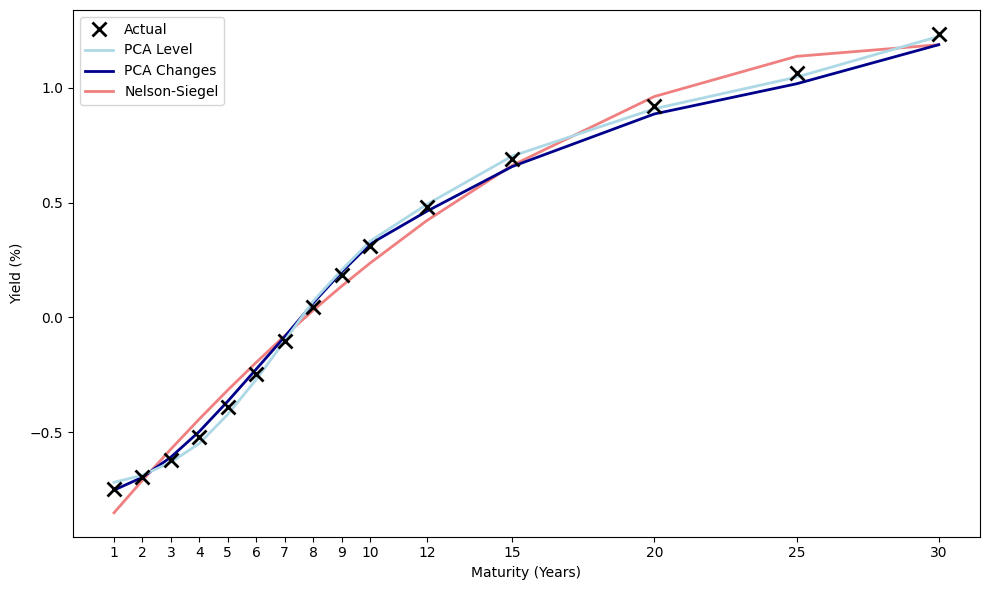


Fit Summary for 2017-05-30:
  PCA Level RMSE: 0.0196 bp
  PCA Changes RMSE: 0.0251 bp
  NS RMSE: 0.0574 bp

Ratio Analysis:
  PCA Level/NS: 0.3418 (PCA Level 65.8% better)
  PCA Level/Changes: 0.7824 (PCA Level 21.8% better)
  PCA Changes/NS: 0.4368 (PCA Changes 56.3% better)

Stability Ratios (Stale/Fresh):
  PCA Level: 0.7040
  PCA Changes: 1.0569
  NS: 1.0000


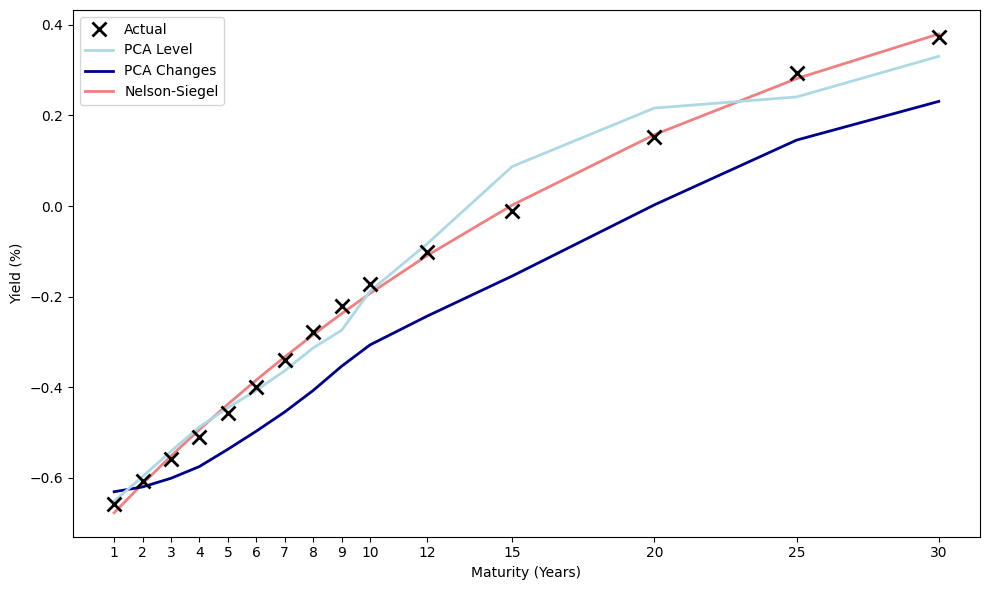


Fit Summary for 2019-12-30:
  PCA Level RMSE: 0.0405 bp
  PCA Changes RMSE: 0.1135 bp
  NS RMSE: 0.0131 bp

Ratio Analysis:
  PCA Level/NS: 3.0889 (PCA Level 208.9% worse)
  PCA Level/Changes: 0.3572 (PCA Level 64.3% better)
  PCA Changes/NS: 8.6470 (PCA Changes 764.7% worse)

Stability Ratios (Stale/Fresh):
  PCA Level: 1.2308
  PCA Changes: 1.1020
  NS: 0.9980


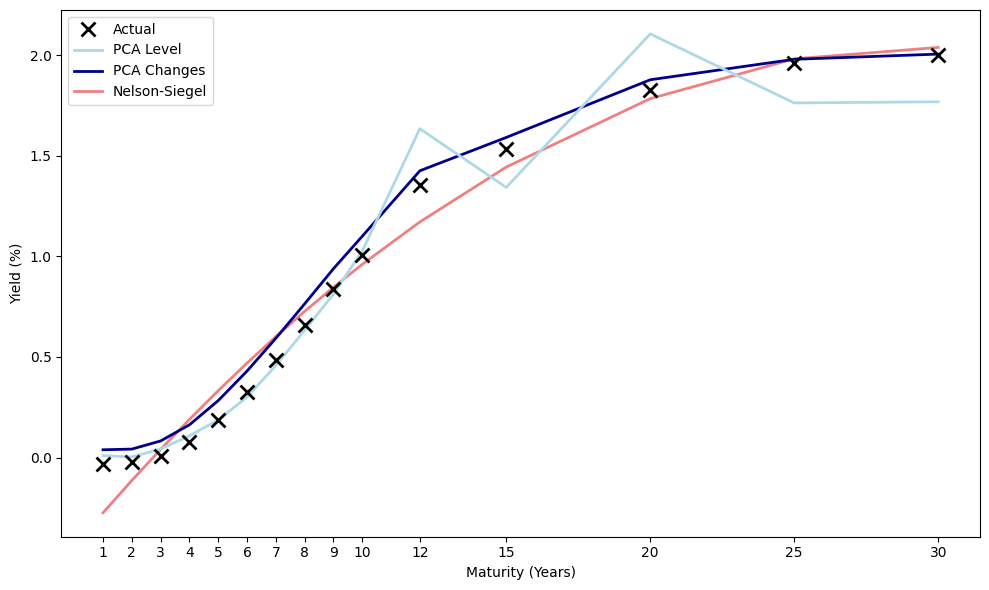


Fit Summary for 2014-09-05:
  PCA Level RMSE: 0.1396 bp
  PCA Changes RMSE: 0.0805 bp
  NS RMSE: 0.1125 bp

Ratio Analysis:
  PCA Level/NS: 1.2418 (PCA Level 24.2% worse)
  PCA Level/Changes: 1.7352 (PCA Level 73.5% worse)
  PCA Changes/NS: 0.7157 (PCA Changes 28.4% better)

Stability Ratios (Stale/Fresh):
  PCA Level: 1.0291
  PCA Changes: 1.0212
  NS: 1.0000


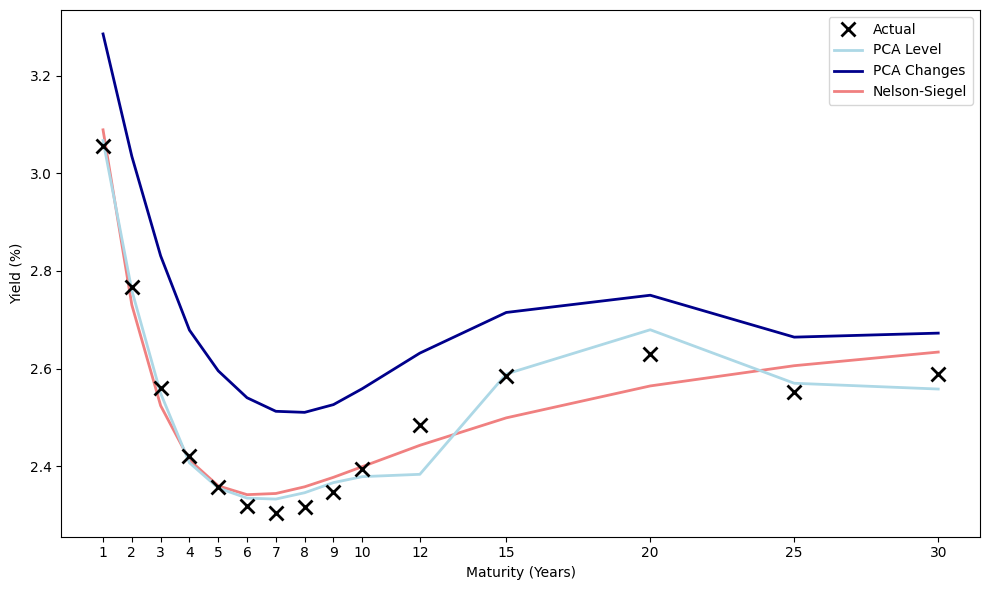


Fit Summary for 2024-06-24:
  PCA Level RMSE: 0.0337 bp
  PCA Changes RMSE: 0.1972 bp
  NS RMSE: 0.0421 bp

Ratio Analysis:
  PCA Level/NS: 0.8008 (PCA Level 19.9% better)
  PCA Level/Changes: 0.1711 (PCA Level 82.9% better)
  PCA Changes/NS: 4.6796 (PCA Changes 368.0% worse)

Stability Ratios (Stale/Fresh):
  PCA Level: 0.9862
  PCA Changes: 1.0495
  NS: 0.9984


In [17]:
#plot_yield_curve_fit('2024-06-24')
#plot_yield_curve_fit('2024-07-23')
#plot_yield_curve_fit('2014-07-08')
plot_yield_curve_fit('2017-05-30') # Best PCA/NS ratio
plot_yield_curve_fit('2019-12-30') # Worst PCA/NS ratio
plot_yield_curve_fit('2014-09-05') # Worst PCA fit
plot_yield_curve_fit('2024-06-24') # Worst NS fit

# Forecasting using VAR

## PCA

In [1]:
# ============================================
# VAR BASELINE FORECASTING - PCA FACTORS
# With IV, No look-ahead bias, Persistence check
# ============================================

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
import os

print("="*80)
print("VAR BASELINE: NO LOOK-AHEAD BIAS + IV")
print("="*80)

# ============================================
# PARAMETERS
# ============================================

min_obs = 300
lags = 3
gap = 21  # Gap to avoid look-ahead bias

print(f"\nParameters:")
print(f"  Minimum observations: {min_obs}")
print(f"  VAR lags: {lags}")
print(f"  Gap (to avoid look-ahead): {gap} rows")
print(f"  Exogenous: IV (current date, no lags)")

# ============================================
# LOAD DATA
# ============================================

print(f"\n{'='*80}")
print("LOADING DATA")
print("="*80)

filepath = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data"

# Load PCA data
df_pca = pd.read_csv(os.path.join(filepath, "PCA_fit.csv"))
df_pca['CURRENT_DATE'] = pd.to_datetime(df_pca['CURRENT_DATE'], format='%d/%m/%Y')
df_pca['FORECASTED_DATE'] = pd.to_datetime(df_pca['FORECASTED_DATE'], format='%d/%m/%Y')

print(f"✓ Loaded df_pca: {len(df_pca)} rows")

# Merge IV from existing df (already has IV column)
df_pca = df_pca.merge(
    df[['REFERENCE_DATE', 'IV']], 
    left_on='CURRENT_DATE', 
    right_on='REFERENCE_DATE', 
    how='left'
).drop(columns=['REFERENCE_DATE'])

# Check for missing IV and interpolate
missing_before = df_pca['IV'].isna().sum()
print(f"\n⚠ Missing IV values before interpolation: {missing_before}")

if missing_before > 0:
    # Show some missing dates
    missing_dates = df_pca[df_pca['IV'].isna()]['CURRENT_DATE'].head(10)
    print(f"  Sample missing dates: {[d.strftime('%Y-%m-%d') for d in missing_dates]}")
    
    # Linear interpolation
    df_pca['IV'] = df_pca['IV'].interpolate(method='linear', limit_direction='both')
    
    missing_after = df_pca['IV'].isna().sum()
    print(f"✓ Interpolated IV")
    print(f"  Remaining missing: {missing_after}")

# Check final IV coverage
iv_coverage = df_pca['IV'].notna().sum()
print(f"\n✓ Final IV statistics:")
print(f"  Coverage: {iv_coverage}/{len(df_pca)} ({iv_coverage/len(df_pca)*100:.1f}%)")
print(f"  Mean: {df_pca['IV'].mean():.2f}")
print(f"  Std: {df_pca['IV'].std():.2f}")
print(f"  Min: {df_pca['IV'].min():.2f}")
print(f"  Max: {df_pca['IV'].max():.2f}")
# ============================================
# PREPARE DATA
# ============================================

current_factor_cols = ['CURRENT_PC1', 'CURRENT_PC2', 'CURRENT_PC3', 'CURRENT_PC4']
future_factor_cols = ['FUTURE_PC1', 'FUTURE_PC2', 'FUTURE_PC3', 'FUTURE_PC4']

for col in current_factor_cols + future_factor_cols + ['IV']:
    df_pca[col] = df_pca[col].astype(np.float64)

# ============================================
# VAR + PERSISTENCE FORECASTS
# ============================================

print(f"\n{'='*80}")
print("RUNNING VAR + PERSISTENCE FORECASTS")
print("="*80)

forecast_rows = []

start_idx = min_obs + lags + gap
end_idx = len(df_pca)

n_forecasts = end_idx - start_idx
print(f"\nGenerating {n_forecasts} forecasts...")
print(f"  First forecast: row {start_idx} (date {df_pca.iloc[start_idx]['CURRENT_DATE'].date()})")

progress_interval = max(1, n_forecasts // 10)
error_count = 0

for i in range(start_idx, end_idx):
    if (i - start_idx) % progress_interval == 0:
        progress = ((i - start_idx) / n_forecasts) * 100
        print(f"  Progress: {progress:.0f}% (errors: {error_count})")
    
    estimation_date = df_pca.iloc[i]['CURRENT_DATE']
    forecast_date = df_pca.iloc[i]['FORECASTED_DATE']
    
    # Training window: end 21 rows before forecast point
    train_end = i - gap
    train_start = train_end - min_obs
    
    # Extract training data
    current_train = df_pca.iloc[train_start:train_end][current_factor_cols].values
    iv_train = df_pca.iloc[train_start:train_end]['IV'].values
    
    # Current IV for forecasting
    iv_current = df_pca.iloc[i]['IV']
    
    if np.any(~np.isfinite(current_train)) or np.any(~np.isfinite(iv_train)) or not np.isfinite(iv_current):
        error_count += 1
        continue
    
    # Try VAR with IV, fall back to VAR without IV if it fails
    fc_var = None
    
    try:
        # Try VARMAX with IV
        # Standardize IV for numerical stability
        iv_mean = iv_train.mean()
        iv_std = iv_train.std()
        iv_train_scaled = (iv_train - iv_mean) / iv_std
        iv_current_scaled = (iv_current - iv_mean) / iv_std
        
        model = VARMAX(
            current_train,
            exog=iv_train_scaled.reshape(-1, 1),
            order=(lags, 0),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        var_result = model.fit(
            disp=False, 
            maxiter=500,  # Reduced from 1000
            method='lbfgs',
            low_memory=True
        )
        
        # Forecast using current IV
        fc_var = var_result.forecast(steps=1, exog=np.array([[iv_current_scaled]]))
        fc_var = fc_var.iloc[0].values
        
    except Exception as e:
        # Fall back to simple VAR without IV
        try:
            from statsmodels.tsa.api import VAR as SimpleVAR
            model_simple = SimpleVAR(current_train)
            var_result_simple = model_simple.fit(maxlags=lags, ic=None)
            
            # Use last lags observations to forecast
            recent = current_train[-lags:]
            fc_var = var_result_simple.forecast(recent, steps=1)[0]
            
        except Exception as e2:
            error_count += 1
            continue
    
    if fc_var is None:
        error_count += 1
        continue
    
    # ============================================
    # PERSISTENCE FORECAST (PC_t = PC_{t-1})
    # ============================================
    fc_persistence = df_pca.iloc[i-1][current_factor_cols].values
    
    # ============================================
    # ACTUAL
    # ============================================
    actual_future = df_pca.iloc[i][future_factor_cols].values
    
    row = {
        'ESTIMATION_DATE': estimation_date,
        'FORECAST_DATE': forecast_date,
        'IV_CURRENT': float(iv_current),
        # VAR forecasts
        'PC1_FORECAST_VAR': float(fc_var[0]),
        'PC2_FORECAST_VAR': float(fc_var[1]),
        'PC3_FORECAST_VAR': float(fc_var[2]),
        'PC4_FORECAST_VAR': float(fc_var[3]),
        # Persistence forecasts
        'PC1_FORECAST_PERS': float(fc_persistence[0]),
        'PC2_FORECAST_PERS': float(fc_persistence[1]),
        'PC3_FORECAST_PERS': float(fc_persistence[2]),
        'PC4_FORECAST_PERS': float(fc_persistence[3]),
        # Actuals
        'PC1_ACTUAL': float(actual_future[0]),
        'PC2_ACTUAL': float(actual_future[1]),
        'PC3_ACTUAL': float(actual_future[2]),
        'PC4_ACTUAL': float(actual_future[3])
    }
    
    forecast_rows.append(row)

print(f"\n✓ Completed {len(forecast_rows)} forecasts (errors: {error_count})")

# ============================================
# CALCULATE ERRORS
# ============================================

df_results = pd.DataFrame(forecast_rows)

for pc in range(1, 5):
    # VAR errors
    df_results[f'PC{pc}_ERROR_VAR'] = df_results[f'PC{pc}_ACTUAL'] - df_results[f'PC{pc}_FORECAST_VAR']
    df_results[f'PC{pc}_ABS_ERROR_VAR'] = np.abs(df_results[f'PC{pc}_ERROR_VAR'])
    df_results[f'PC{pc}_SQ_ERROR_VAR'] = df_results[f'PC{pc}_ERROR_VAR']**2
    
    # Persistence errors
    df_results[f'PC{pc}_ERROR_PERS'] = df_results[f'PC{pc}_ACTUAL'] - df_results[f'PC{pc}_FORECAST_PERS']
    df_results[f'PC{pc}_ABS_ERROR_PERS'] = np.abs(df_results[f'PC{pc}_ERROR_PERS'])
    df_results[f'PC{pc}_SQ_ERROR_PERS'] = df_results[f'PC{pc}_ERROR_PERS']**2

# ============================================
# COMPARE VAR vs PERSISTENCE
# ============================================

print(f"\n{'='*80}")
print("VAR vs PERSISTENCE COMPARISON")
print("="*80)

for pc in range(1, 5):
    rmse_var = np.sqrt(df_results[f'PC{pc}_SQ_ERROR_VAR'].mean())
    rmse_pers = np.sqrt(df_results[f'PC{pc}_SQ_ERROR_PERS'].mean())
    mae_var = df_results[f'PC{pc}_ABS_ERROR_VAR'].mean()
    mae_pers = df_results[f'PC{pc}_ABS_ERROR_PERS'].mean()
    
    improvement = ((rmse_pers - rmse_var) / rmse_pers * 100) if rmse_var < rmse_pers else -((rmse_var - rmse_pers) / rmse_pers * 100)
    
    print(f"\nPC{pc}:")
    print(f"  VAR:         RMSE={rmse_var:.6f}, MAE={mae_var:.6f}")
    print(f"  Persistence: RMSE={rmse_pers:.6f}, MAE={mae_pers:.6f}")
    print(f"  Improvement: {improvement:+.1f}%")

# Overall
overall_rmse_var = np.sqrt(df_results[[f'PC{i}_SQ_ERROR_VAR' for i in range(1,5)]].values.mean())
overall_rmse_pers = np.sqrt(df_results[[f'PC{i}_SQ_ERROR_PERS' for i in range(1,5)]].values.mean())
improvement_overall = ((overall_rmse_pers - overall_rmse_var) / overall_rmse_pers * 100)

print(f"\nOverall:")
print(f"  VAR:         RMSE={overall_rmse_var:.6f}")
print(f"  Persistence: RMSE={overall_rmse_pers:.6f}")
print(f"  Improvement: {improvement_overall:+.1f}%")

# Save
baseline_path = os.path.join(filepath, "VAR_PCA_baseline.csv")
df_results.to_csv(baseline_path, index=False)
print(f"\n✓ Saved: {baseline_path}")

print(f"\n{'='*80}")
print("✓ VAR BASELINE COMPLETE")
print("="*80)

VAR BASELINE: NO LOOK-AHEAD BIAS + IV

Parameters:
  Minimum observations: 300
  VAR lags: 3
  Gap (to avoid look-ahead): 21 rows
  Exogenous: IV (current date, no lags)

LOADING DATA
✓ Loaded df_pca: 3048 rows


NameError: name 'df' is not defined

In [6]:
# ============================================
# VISUALIZE VAR BASELINE RESULTS
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

print("="*80)
print("VAR BASELINE RESULTS ANALYSIS")
print("="*80)

# ============================================
# LOAD RESULTS
# ============================================

filepath = r"\\GIMECB01\HOMEDIR-VZ$\westenb\Thesis\Data"
df_var_baseline = pd.read_csv(os.path.join(filepath, "VAR_PCA_baseline.csv"))
df_var_baseline['ESTIMATION_DATE'] = pd.to_datetime(df_var_baseline['ESTIMATION_DATE'])
df_var_baseline['FORECAST_DATE'] = pd.to_datetime(df_var_baseline['FORECAST_DATE'])

print(f"\n✓ Loaded results: {len(df_var_baseline)} forecasts")
print(f"  Date range: {df_var_baseline['ESTIMATION_DATE'].min().date()} to {df_var_baseline['ESTIMATION_DATE'].max().date()}")

# ============================================
# CLARIFICATION
# ============================================

print(f"\n{'='*80}")
print("DATA CLARIFICATION")
print("="*80)
print("\nPC_ACTUAL values are FUTURE_PC1-4 from df_pca:")
print("  - Extracted 21 days ahead (at time t+21)")
print("  - Using stale loadings from time t")
print("  - This is what we're trying to forecast")
print("\nPC_FORECAST values are VAR predictions:")
print("  - Based on CURRENT_PC1-4 history")
print("  - Forecasting 21 steps ahead")

# ============================================
# PERFORMANCE METRICS BY YEAR
# ============================================

print(f"\n{'='*80}")
print("PERFORMANCE METRICS BY YEAR")
print("="*80)

df_var_baseline['YEAR'] = df_var_baseline['ESTIMATION_DATE'].dt.year

print("\nRMSE by Year:")
for year in sorted(df_var_baseline['YEAR'].unique()):
    year_data = df_var_baseline[df_var_baseline['YEAR'] == year]
    rmse = np.sqrt(year_data[[f'PC{i}_SQ_ERROR' for i in range(1,5)]].values.mean())
    print(f"  {year}: {rmse:.6f}")

# ============================================
# TIME SERIES PLOTS
# ============================================

print(f"\n{'='*80}")
print("CREATING VISUALIZATIONS")
print("="*80)

# Plot 1: Forecasted vs Actual for each PC
fig, axes = plt.subplots(4, 1, figsize=(14, 12))
fig.suptitle('VAR Baseline: Forecasted vs Actual Principal Components (21-day ahead)', 
             fontsize=14, fontweight='bold')

for i, pc in enumerate(range(1, 5)):
    ax = axes[i]
    
    # Plot actual and forecast
    ax.plot(df_var_baseline['ESTIMATION_DATE'], 
            df_var_baseline[f'PC{pc}_ACTUAL'], 
            label=f'Actual PC{pc}', color='darkblue', linewidth=1.5, alpha=0.7)
    ax.plot(df_var_baseline['ESTIMATION_DATE'], 
            df_var_baseline[f'PC{pc}_FORECAST'], 
            label=f'Forecast PC{pc}', color='red', linewidth=1.2, alpha=0.6)
    
    ax.set_ylabel(f'PC{pc}', fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Add RMSE to title
    rmse = np.sqrt(df_var_baseline[f'PC{pc}_SQ_ERROR'].mean())
    mae = df_var_baseline[f'PC{pc}_ABS_ERROR'].mean()
    ax.set_title(f'PC{pc}: RMSE={rmse:.6f}, MAE={mae:.6f}', fontsize=10)

axes[-1].set_xlabel('Estimation Date', fontsize=11)
plt.tight_layout()
plt.show()

print("✓ Figure 1: Forecasted vs Actual PCs")

# Plot 2: Forecast Errors over Time
fig, axes = plt.subplots(4, 1, figsize=(14, 12))
fig.suptitle('VAR Baseline: Forecast Errors Over Time (21-day ahead)', 
             fontsize=14, fontweight='bold')

for i, pc in enumerate(range(1, 5)):
    ax = axes[i]
    
    # Plot error
    ax.plot(df_var_baseline['ESTIMATION_DATE'], 
            df_var_baseline[f'PC{pc}_ERROR'], 
            color='darkred', linewidth=1, alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    # Add ±1 std bands
    std = df_var_baseline[f'PC{pc}_ERROR'].std()
    ax.axhline(y=std, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    ax.axhline(y=-std, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    
    ax.set_ylabel(f'PC{pc} Error', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Add stats to title
    mean_error = df_var_baseline[f'PC{pc}_ERROR'].mean()
    ax.set_title(f'PC{pc}: Mean Error={mean_error:.6f}, Std={std:.6f}', fontsize=10)

axes[-1].set_xlabel('Estimation Date', fontsize=11)
plt.tight_layout()
plt.show()

print("✓ Figure 2: Forecast Errors Over Time")

# Plot 3: Absolute Errors over Time
fig, axes = plt.subplots(4, 1, figsize=(14, 12))
fig.suptitle('VAR Baseline: Absolute Forecast Errors Over Time (21-day ahead)', 
             fontsize=14, fontweight='bold')

for i, pc in enumerate(range(1, 5)):
    ax = axes[i]
    
    # Plot absolute error
    ax.plot(df_var_baseline['ESTIMATION_DATE'], 
            df_var_baseline[f'PC{pc}_ABS_ERROR'], 
            color='darkgreen', linewidth=1, alpha=0.7)
    
    # Add MAE line
    mae = df_var_baseline[f'PC{pc}_ABS_ERROR'].mean()
    ax.axhline(y=mae, color='red', linestyle='--', linewidth=1.5, 
               label=f'MAE={mae:.6f}')
    
    ax.set_ylabel(f'|PC{pc} Error|', fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Estimation Date', fontsize=11)
plt.tight_layout()
plt.show()

print("✓ Figure 3: Absolute Errors Over Time")

# Plot 4: Error Distribution (Histograms)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('VAR Baseline: Error Distributions', fontsize=14, fontweight='bold')

for i, pc in enumerate(range(1, 5)):
    ax = axes[i//2, i%2]
    
    errors = df_var_baseline[f'PC{pc}_ERROR']
    
    ax.hist(errors, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.axvline(x=errors.mean(), color='orange', linestyle='--', linewidth=2, 
               label=f'Mean={errors.mean():.6f}')
    
    ax.set_xlabel(f'PC{pc} Error', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'PC{pc}: Skew={errors.skew():.3f}, Kurt={errors.kurtosis():.3f}', 
                 fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Figure 4: Error Distributions")

# ============================================
# DETAILED STATISTICS
# ============================================

print(f"\n{'='*80}")
print("DETAILED FORECAST STATISTICS")
print("="*80)

stats_summary = []
for pc in range(1, 5):
    errors = df_var_baseline[f'PC{pc}_ERROR']
    abs_errors = df_var_baseline[f'PC{pc}_ABS_ERROR']
    
    stats = {
        'Factor': f'PC{pc}',
        'RMSE': np.sqrt((errors**2).mean()),
        'MAE': abs_errors.mean(),
        'Mean Error': errors.mean(),
        'Std Error': errors.std(),
        'Min Error': errors.min(),
        'Max Error': errors.max(),
        'Median AE': abs_errors.median()
    }
    stats_summary.append(stats)

stats_df = pd.DataFrame(stats_summary)
print("\n" + stats_df.to_string(index=False))

# ============================================
# ANALYSIS & REFLECTION
# ============================================



print("\n📈 BENCHMARK QUALITY:")
rmse_pc1 = np.sqrt(df_var_baseline['PC1_SQ_ERROR'].mean())
std_pc1 = df_var_baseline['PC1_ACTUAL'].std()
skill_pc1 = 1 - (rmse_pc1 / std_pc1)

print(f"  Forecast Skill (PC1): {skill_pc1:.1%}")
print(f"    (Skill = 1 - RMSE/StdDev, >0 is better than persistence)")

if skill_pc1 > 0.3:
    print("  ✓ This is a GOOD baseline (>30% skill)")
elif skill_pc1 > 0:
    print("  ✓ This is a REASONABLE baseline (positive skill)")
else:
    print("  ⚠ Baseline is weak (no skill over persistence)")

print(f"\n{'='*80}")
print("✓ ANALYSIS COMPLETE")
print("="*80)

VAR BASELINE RESULTS ANALYSIS

✓ Loaded results: 2724 forecasts
  Date range: 2015-04-09 to 2025-12-17

DATA CLARIFICATION

PC_ACTUAL values are FUTURE_PC1-4 from df_pca:
  - Extracted 21 days ahead (at time t+21)
  - Using stale loadings from time t
  - This is what we're trying to forecast

PC_FORECAST values are VAR predictions:
  - Based on CURRENT_PC1-4 history
  - Forecasting 21 steps ahead

PERFORMANCE METRICS BY YEAR

RMSE by Year:


KeyError: "None of [Index(['PC1_SQ_ERROR', 'PC2_SQ_ERROR', 'PC3_SQ_ERROR', 'PC4_SQ_ERROR'], dtype='object')] are in the [columns]"